# Setup functions

This should try its best to separate the following:
* Editing individual's relationships to groups
* Groups updating their values
* Any effects on public information



Class-version where you extend the graph class to include the individual function and group function. Good for instantiating many versions of the simulation.

## Universal Functions

In [ ]:
import networkx as nx
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import time
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")
import functools
from copy import deepcopy
import scipy.stats as stats
import itertools
import warnings

In [ ]:
def doNothing(self, public_info): #For debugging purposes when a function needs to be passed in
  pass

clamp = lambda n, minn, maxn: max(min(maxn, n), minn)

def calculateMean(netw, groupname, s=1):
  groupneighs = list(netw.neighbors(groupname))
  thismean = None
  if len(groupneighs)>0:
    thismean = np.mean( np.vstack( [netw.nodes[eachnode]['valence'] for eachnode in groupneighs] ), axis=0) #Stack the RGB valences and take the mean
  else:
    print('%s has no members'%groupname)
  return thismean

def grabGvalues(netw,grouplist):
  return {i: netw.nodes[i]['mean'] for i in grouplist}

def grabCmeans(netw,grouplist):
  return {i: calculateMean(netw, i) for i in grouplist}

def grabGroupsize(netw,grouplist):
  return {group: len(list(netw.neighbors(group))) for group in grouplist}

# def grabDifferenceStats(netw,grouplist):
#   meanvaldiff
#   meanvalvarr

#   for group in grouplist:
#     list(netw.neighbors(group))

def distMatrix1D(m): #Coded this up quickly because I'm too lazy to import scipy
  m = np.array(m)
  dist = np.tile(m,(len(m),1))
  return np.abs(dist - dist.T)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
class GroupshiftSim():

#===============================================================================
# Intializing
#===============================================================================

  def __init__(self, groupshift_function, indivchoice_function, groupFargs = {}, indivFargs = {}, lowvalence = 0, highvalence =100, s = 1, inittype='random', save_timesteps = []):
    self.lowvalence = lowvalence
    self.highvalence = highvalence
    self.s = s
    self.groupShift = groupshift_function
    self.indivChoice = indivchoice_function
    if inittype not in ['random', 'sorted']:
      raise Exception("Invalid type of graph connectivity initialization for this groupshift simulation.")

    #Statistics savers
    self.saved_graphs = {}
    self.savegvalues = []
    self.savecmeans = []
    self.savesizes = []
    #Group dists vs group sizes
#    self.savegroupdists_gdvgs = []
#    self.savegroupswaps_gdvgs = []
    #Robmetric
    self.savegroupdists_rmc = []
    self.savegroupdeltas_rmc = []
    #Robmetric simple
    self.savegroup_delGx = []
    self.savegroup_delGy = []
    self.save_timesteps = [0] + save_timesteps

    #Other arguments
    self.groupFargs = groupFargs
    self.indivFargs = indivFargs

  def initializeNodes(self, num_nodes, num_groups, initdist):
    self.num_nodes = num_nodes
    self.num_groups = num_groups
    self.grouplist = ['Group%i'%i for i in range(num_groups)]
    self.nodelist = list(range(num_nodes))

    #Creating graph
    self.g = nx.Graph()
    if initdist == 'random':
      nodes_with_valence = [(i,{'valence':np.random.randint(self.lowvalence,self.highvalence, size=self.s)}) for i in self.nodelist]
      self.g.add_nodes_from( nodes_with_valence )   #Add nodes with attribute 'valence': (R,G,B)
      self.g.add_nodes_from( self.grouplist ) #Add grouplist nodes WITHOUT THEIR MEANS
      self.g.add_edges_from( [(i,np.random.choice(self.grouplist)) for i in self.nodelist] )  #Add edges randomly between nodes and grouplist nodes
    elif initdist == 'normal':
      nodes_with_valence = [(i, {'valence': np.clip(np.random.normal((self.highvalence-self.lowvalence)/2, 15, size=self.s),self.lowvalence,self.highvalence) }) for i in self.nodelist]
        #Manually input the stdev because it's easier to set that than calculate it
        #Clamped it to [lowvalence,highvalence] just in case
      self.g.add_nodes_from( nodes_with_valence )   #Add nodes with attribute 'valence': (R,G,B)
      self.g.add_nodes_from( self.grouplist ) #Add grouplist nodes WITHOUT THEIR MEANS
      self.g.add_edges_from( [(i,np.random.choice(self.grouplist)) for i in self.nodelist] )  #Add edges randomly between nodes and grouplist nodes
    elif initdist == 'sorted':
      self.g.add_nodes_from( self.grouplist )
      self.g.add_nodes_from( self.nodelist )
      edgelist = [(i,np.random.choice(self.grouplist)) for i in self.nodelist]
      self.g.add_edges_from( edgelist )
      #Sort the edges
      sorted_nodes, sorted_groups = zip(*sorted(edgelist, key=lambda kv:(kv[1], kv[0])))
      #Add in values sorted, and map it to the sorted edges
      sorted_valences = sorted( [np.random.randint(self.lowvalence,self.highvalence, size=self.s) for i in range(self.num_nodes)] )
      valence_dict = {sorted_nodes[i]: sorted_valences[i] for i in range(len(sorted_nodes)) }
      nx.set_node_attributes(self.g, valence_dict, 'valence')

#===============================================================================
# Running simulations, saving data
#===============================================================================

  def runSimulation(self, timesteps):
    self.timesteps = timesteps
    self.save_timesteps.append(timesteps-1) #Automatically save the last timestep

    #Transform arguments in kwargs into arrays if they are not already arrays
    for k in self.groupFargs.keys():
      #If the argument is not an array...
      if type(self.groupFargs[k]) != list:
        self.groupFargs[k] = [self.groupFargs[k] for i in range(timesteps)] #...turn it into an array (I did not do this by multiplying because I don't want the entire thing to copy a referent)
      #If the argument is an array...
      elif (type(self.groupFargs[k])) == list:
        #Warning if the array mismatches the number of timesteps
        if len(self.groupFargs[k]) != timesteps:
          warnings.warn("\nWarning: The variable " + str(k) + " in the group function's arguments is an array of the wrong size. Expected length of " + str(timesteps) +
                        " but received " + str(len(self.groupFargs[k])) + ". \nReminder! Arrays too short will sustain the final value; values beyond the number of timesteps will be ignored.")
          #If the list is too short...
          if len(self.groupFargs[k]) < timesteps:
            #...repeat the final value until it matches the number of timesteps
            self.groupFargs[k] += [self.groupFargs[k][-1]] * (timesteps - len(self.groupFargs[k]))

    for t in tqdm(range(self.timesteps)):
      #Save out the graph data
      if t in self.save_timesteps:
        self.saved_graphs[t] = deepcopy(self.g)

      #Pick out this timestep's parameters for the group and individual functions
      these_groupFargs = {k: self.groupFargs[k][t] for k in self.groupFargs.keys()}
      these_indivFargs = {k: self.indivFargs[k][t] for k in self.indivFargs.keys()}

      #Perform group shift function
      self.groupShift(self, **these_groupFargs)

      #Save out the statistical data
      self.savebasics()

      #self.groupdistVgroupswap()
      self.robMetric()
      self.robMetricSimple()

      #Perform node selection step function
      public_information = grabGvalues(self.g,self.grouplist)
      self.indivChoice(self, public_information, **these_indivFargs) #How to parameterize?

#===============================================================================
# Calculate statistics
#===============================================================================

  def savebasics(self):
      thesegvals = deepcopy(grabGvalues(self.g,self.grouplist))
      thesesizes = deepcopy(grabGroupsize(self.g,self.grouplist))
      thesecmeans = deepcopy(grabCmeans(self.g, self.grouplist))
      self.savegvalues.append(thesegvals)
      self.savecmeans.append(thesecmeans)
      self.savesizes.append(thesesizes)

  # def groupdistVgroupswap(self): #Metric code gdvds
  #   #Save numbers for the [distance between group A and B], and the [proportion of people who would prefer to be in the other group]
  #   groupmeans_dict = deepcopy(grabMeans(self.g,self.grouplist))
  #   num_groups = len(groupmeans_dict)
  #   groupmeans_flat = [groupmeans_dict['Group%i'%i] for i in range(num_groups)] #Assumes that the groups are ordered from Group1-10
  #   groupdists = distMatrix1D(groupmeans_flat)

  #   groupswaps = np.zeros((num_groups,num_groups))
  #   for i,j in itertools.combinations(range(num_groups),2): #For every pair of group
  #     groupA = 'Group%i'%i
  #     groupB = 'Group%i'%j
  #     groupA_val = self.g.nodes[groupA]['mean']
  #     groupB_val = self.g.nodes[groupB]['mean']
  #     #Calculate proportion of people in optimal position vs suboptimal
  #     group_stay = set([])
  #     group_switch = set([])
  #     ppl_groupA = set(self.g.neighbors(groupA))
  #     ppl_groupB = set(self.g.neighbors(groupB))
  #     for person in ppl_groupA:
  #       #If distance to own group is greater...
  #       if np.abs(groupA_val - self.g.nodes[person]['valence']) > np.abs(groupB_val - self.g.nodes[person]['valence']): #This assumes 1d valence
  #         group_switch.add(person)
  #       else:
  #         group_stay.add(person)
  #     for person in ppl_groupB:
  #       if np.abs(groupB_val - self.g.nodes[person]['valence']) > np.abs(groupA_val - self.g.nodes[person]['valence']): #This assumes 1d valence
  #         group_switch.add(person)
  #       else:
  #         group_stay.add(person)
  #     value = float(len(group_switch)) / (len(group_stay)+len(group_switch))
  #     groupswaps[i,j] = value
  #     groupswaps[j,i] = value

  #   self.savegroupdists_gdvgs.append(groupdists)
  #   self.savegroupswaps_gdvgs.append(groupswaps)

  def robMetric(self): #Metric code rmc
    #Calculate mean of G minus G (mu(G) - G) for group1 and group 2
    #Call this delG_1 = (mu(G_1) - G_1)
    #Plot that as...signed difference of G_1 - G_2 VERSUS delG_1 - delG_2
    groupdists_signed = np.zeros((self.num_groups,self.num_groups))
    groupdeltas = np.zeros((num_groups,num_groups))

    for i,j in itertools.combinations(range(num_groups),2): #For every pair of groupt
      group1 = 'Group%i'%i
      group2 = 'Group%i'%j
      groupdists_signed[i,j] = self.g.nodes[group2]['mean'] - self.g.nodes[group1]['mean']
      groupdists_signed[j,i] = self.g.nodes[group1]['mean'] - self.g.nodes[group2]['mean']
      if len(list(self.g.neighbors(group1))) > 0 and len(list(self.g.neighbors(group2))) > 0:
        mu_1 = calculateMean(self.g, group1)
        mu_2 = calculateMean(self.g, group2)
        #The following effect is signed, so the value is different depending on direction
        groupdeltas[i,j] = (mu_2 - self.g.nodes[group2]['mean']) - (mu_1 - self.g.nodes[group1]['mean'])
        groupdeltas[j,i] = (mu_1 - self.g.nodes[group1]['mean']) - (mu_2 - self.g.nodes[group2]['mean'])
      else:                                                                                             #<--WHAT SHOULD THE VALUE BE IF ONE OF THE GROUPS DOESN'T HAVE MEMBERS?
        groupdeltas[i,j] = -1000
        groupdeltas[j,i] = -1000

    self.savegroupdists_rmc.append(groupdists_signed)
    self.savegroupdeltas_rmc.append(groupdeltas)

  def robMetricSimple(self):
    #Calculate delG_1 on its own
    #Plot this against the value of G

    delGs = {}
    for group in self.grouplist:
      if len(list(self.g.neighbors(group))) > 0:
        mu = calculateMean(self.g, group)
        delG = mu - self.g.nodes[group]['mean']
        delGs[group] = delG
      else:                                                                                            #<--WHAT SHOULD THE VALUE BE IF ONE OF THE GROUPS DOESN'T HAVE MEMBERS?
        delGs[group] = -10

    self.savegroup_delGx.append( grabGvalues(self.g,self.grouplist) )
    self.savegroup_delGy.append( delGs )

  def howManyUnsorted(self):
    #Calculate how many people are not in their optimal group
    pass

#===============================================================================
# Plotting functions
#===============================================================================

  def plotTimelineMeans(self, legend=True):
    #Grabbing and plotting means over time
    gvaluedata = {i:[] for i in self.grouplist}
    for m in self.savegvalues:
      for group in self.grouplist:
        gvaluedata[group].append(m[group])

    cmeandata = {i:[] for i in self.grouplist}
    for m in self.savecmeans:
      for group in self.grouplist:
        cmeandata[group].append(m[group])

    plt.figure(figsize=(15,10))
    for group in self.grouplist:
      intermediate_gval_data = np.array(gvaluedata[group]).T
      plt.plot(intermediate_gval_data[0], linewidth=1, label=group)
      intermediate_cmean_data = np.array(cmeandata[group]).T
      plt.plot(intermediate_cmean_data[0], '-.', label=group+" members")

    plt.title("Group value over time, 1D")
    plt.xlabel("Time (t)")
    plt.ylabel("Group value")
    plt.ylim((self.lowvalence,self.highvalence))
    #plt.ylim(self.lowvalence,self.highvalence)
    if legend:
      plt.legend()
    plt.show()

  #-----------------------------------------------------------------------------
  def plotTimelineSizes(self, legend=True):
    #Constructing a tidy dataframe
    to_dataframe = {'group': [], 'timestep': [], 'size': []}
    for i, m in enumerate(self.savesizes):
      for group in self.grouplist:
        to_dataframe['group'].append(group)
        to_dataframe['timestep'].append(i)
        to_dataframe['size'].append(m[group])

    modeldf = pd.DataFrame(to_dataframe)
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.lineplot(x='timestep', y='size', hue='group', data = modeldf, linewidth=1, legend=legend).set(title="Group sizes over time")
    plt.show()


  #------------------
  def plotIndivDist(self, t='now', overall = True, legend=True):
    if t=='now':
      thisgraph = self.g
    elif type(t) == int:
      if t not in self.saved_graphs:
        raise Exception("The graph at the timestep you requested has not been saved. This timestep is not available.")
      thisgraph = self.saved_graphs[t]
    else:
      raise Exception("Invalid input for timeslice parameter for plotting the distribution of individual values.")

    agent_valences = nx.get_node_attributes(thisgraph,'valence')
    agent_sets = {xx:list(thisgraph.neighbors(xx)) for xx in self.grouplist} #Grab the agents associated with each group
    agent_sets_valence = {xx:[agent_valences[i][0] for i in agent_sets[xx]] for xx in self.grouplist} #Grab the valence associated with each agent, by group


    if overall:
      agent_valences_squish = [x[0] for x in agent_valences.values()]
      sns.set(rc={'figure.figsize':(11.7,8.27)})
      sns.displot(agent_valences_squish, bins=15, kde=True).set(title='Distributions of agent opinions, all')
      plt.xlabel('Valence')
      plt.ylabel('Num agents')
    else:
      data_to_plot = [agent_sets_valence[xx] for xx in self.grouplist]
      sns.displot(data_to_plot, kind='kde', legend=legend).set(title="Distributions of agent opinions by group")

  #-----------------------------------------------------------------------------
  def plotDistSwap(self, legend=True, timespan = [], ylimits=[], scattersize = 1):
    if len(timespan)==2 and type(timespan[0]) is int and type(timespan[1]) is int:
      starttime = max(0,timespan[0])
      endtime = min(self.timesteps,timespan[1]) if timespan[1]<self.timesteps else self.timesteps
    else:
      starttime = 0
      endtime = self.timesteps
    print("Plotting timespan from %i to %i..."%(starttime, endtime))

    #Extracting info on group swaps
    #THIS NEEDS TO BE CHECKED IF IT'S PLOTTING VALUES BOTH ABOVE AND BELOW THE DIAGONAL
    for i in range(self.num_groups):
      for j in range(self.num_groups):
        x = [self.savegroupdists_gdvgs[t][i,j] for t in range(starttime, endtime)]
        y = [self.savegroupswaps_gdvgs[t][i,j] for t in range(starttime, endtime)]
        plt.plot(x,y, label='%i to %i'%(i,j), linewidth=1)

    plt.xlabel("Distance between Group A and Group B")
    plt.ylabel("Percent of people who prefer to switch")
    plt.xlim([0,100])
    if ylimits!=[]:
      plt.ylim(ylimits)
    plt.show()

  #-----------------------------------------------------------------------------
  # Plot Rob's metric (RMC)
  # Rob's metric is trying to measure the extent of the push between groups
  # It's calculated as the difference in the difference of means between the group and its constituents
  # One issue is that it creates a lot of lines because it's defined as a pairwise value, so there's a separate value for each combination of groups over time
  def plotRMC(self, legend=False, timespan = [], ylimits=[], scattersize = 1, individual_plots=False): #Plots for rob's metric

    #THIS CODE SHOULD RAISE A WARNING IF THE DUMMY VALUE APPEARS
    #warnings.warn("At least one member does not have a group, so a dummy variable has been injected. Check plot carefully.")

    if len(timespan)==2 and type(timespan[0]) is int and type(timespan[1]) is int:
      starttime = max(0,timespan[0])
      endtime = min(self.timesteps,timespan[1]) if timespan[1]<self.timesteps else self.timesteps
    else:
      starttime = 0
      endtime = self.timesteps
    print("Plotting timespan from %i to %i..."%(starttime, endtime))

    #THIS CODE NEEDS TO BE CHECKED FOR HOW IT'S PLOTTING VALUES. IS THE ABOVE/BELOW DIAGONAL IMPORTANT?
    for i in range(self.num_groups):
      for j in range(self.num_groups):
        x = [self.savegroupdists_rmc[t][i,j] for t in range(starttime, endtime)]
        y = [self.savegroupdeltas_rmc[t][i,j] for t in range(starttime, endtime)]
        plt.plot(x,y, label='%i to %i'%(i,j), linewidth=1)
        if scattersize > 1:
          plt.scatter(x,y,s=scattersize)
        else:
          plt.plot(x,y, label='%i to %i'%(i,j), linewidth=1)
      if individual_plots:
        plt.xlabel("Distance between Group %i and other groups"%(i))
        plt.ylabel("Discrepancy between constituents for Group %i and other groups"%(i))
        plt.xlim([-100,100])
        if ylimits!=[]:
          plt.ylim(ylimits)
        plt.show()

    if not individual_plots:
      plt.xlabel("Distance between Group A and Group B")
      plt.ylabel("Discrepancy between constituents for Groups A and Group B")
      plt.xlim([-100,100])
      if ylimits!=[]:
        plt.ylim(ylimits)
      plt.show()

  #-----------------------------------------------------------------------------
  # Plot simple RMC
  # This is like rob's metric but it's 'simplified' in the sense that it's just the plot of the difference between a group and its constituents' means.
  # The reason for this is that it captures essentially the same phenomenon as RMC, since the possible difference between two groups is relative to their position on the opinion space
  def plotRMCsimple(self, legend=False, timespan = [], ylimits=[], scattersize = 1):
    if len(timespan)==2 and type(timespan[0]) is int and type(timespan[1]) is int:
      starttime = max(0,timespan[0])
      endtime = min(self.timesteps,timespan[1]) if timespan[1]<self.timesteps else self.timesteps
    else:
      starttime = 0
      endtime = self.timesteps
    print("Plotting timespan from %i to %i..."%(starttime, endtime))

    #Take out values for each
    for group in self.grouplist:
      x = [self.savegroup_delGx[t][group] for t in range(starttime, endtime)]
      y = [self.savegroup_delGy[t][group] for t in range(starttime, endtime)]
      plt.plot(x,y, label=group)
      if scattersize > 1:
        plt.scatter(x,y, s=scattersize)

    plt.xlabel("Group's value")
    plt.ylabel("Discrepancy between group and members")
    plt.xlim([0,100])
    if ylimits!=[]:
      plt.ylim(ylimits)

    plt.show()

## Common functions

Certain functions, like groups calculating their means, will occur across multiple models, but they aren't necessarily universal functions in that they are technically parameters of the model.

In [ ]:
#This function edits a graph in place
def recalcMean(self, netw, groupname, resettype='sust', s=1):
  groupneighs = list(netw.neighbors(groupname))
  if len(groupneighs)>0:
    thismean = np.mean( np.vstack( [netw.nodes[eachnode]['valence'] for eachnode in groupneighs] ), axis=0) #Stack the RGB valences and take the mean
    netw.nodes[groupname]['mean'] = thismean
  else:
    #Set default to zero. This may cause the homogenization
    if resettype == 'zero':
      netw.nodes[groupname]['mean'] = np.zeros(s)
    elif resettype == 'rand':
      #Set default to random.
      netw.nodes[groupname]['mean'] = np.random.randint(self.lowvalence,self.highvalence,size=s)
    elif resettype == 'sust':
      pass #Do nothing and let the mean be the same as it was

def groupshiftSimpleMean(self, resettype='sust', s=1):
  for i in self.grouplist:
    recalcMean(self, self.g, i, resettype=resettype, s=s)

def oneNodeOpenSwitch(self, public_info):
  #Randomly select a node
  thisnode = np.random.choice(self.nodelist)

  #Calculate distances (for colors)
  dists = {}
  for i in public_info:
    dists[i] = np.linalg.norm(public_info[i] - self.g.nodes[thisnode]['valence'])
  #Get the group with the minimum distance
  mingroup = min(dists,key=dists.get)
  #Replace current group edge
  currentgroup = list(self.g.neighbors(thisnode))[0]
  if currentgroup != mingroup:
    self.g.remove_edge(thisnode,currentgroup)
    self.g.add_edge(thisnode,mingroup)


################################################################################
#     REPULSION AND ATTRACTION FUNCTIONS
################################################################################

def groupshiftRepulseAttract(self, rWidth, rAmp, aWidth, aAmp, resettype='sust', s=1):
  gsRepulse(self, rWidth, rAmp, resettype=resettype, s=s)
  gsAttract(self, aWidth, aAmp, resettype=resettype, s=s)

def groupshiftRepulseOnly(self, rWidth, rAmp, aWidth, aAmp, resettype='sust', s=1):
  gsRepulse(self, rWidth, rAmp, resettype=resettype, s=s)

def groupshiftAttractOnly(self, rWidth, rAmp, aWidth, aAmp, resettype='sust', s=1):
  gsAttract(self, aWidth, aAmp, resettype=resettype, s=s)

def doNothingRepulseAttract(self, rWidth, rAmp, aWidth, aAmp, resettype='sust', s=1):
  if 'mean' not in self.g.nodes['Group0']:
    for i in self.grouplist:
      recalcMean(self, self.g, i, resettype=resettype, s=s)

def gsRepulse(self, rWidth, rAmp, resettype, s):
  width = rWidth    #Increases the range of the repulsion effect
    #width will determine the baseline differe
    #width = 1 results in a gradual slow curve with pretty even spread over 10k timesteps
    #width = 100 results in a ~30 value difference between groups fairly quickly
  amp = rAmp      #Increases the amount of pushback that the repulsion effect causes

  if 'mean' not in self.g.nodes['Group0']:
    for i in self.grouplist:
      recalcMean(self, self.g, i, resettype=resettype, s=s)
  #Group repulsion
  #Grab the group means
  groupmeans_dict = nx.get_node_attributes(self.g,'mean') #Get the valences
  groupmeans = [groupmeans_dict[i][0] for i in self.grouplist] #Make sure they're ordered and in list form

  #Calculate distances
  dmatrix = []
  signed_dmatrix = []
  for i in groupmeans:
    dmatrix.append( np.abs(i - np.array(groupmeans)))
    signed_dmatrix.append( i - np.array(groupmeans))
  dmatrix = np.array(dmatrix)
  signed_dmatrix = np.array(signed_dmatrix)

  #Calculate e^(-|A-B|), then multiply it by the sign of the distance value
  update_vals = np.exp(-1 * (1/width) * dmatrix**2)
  update_vals = update_vals * np.sign(signed_dmatrix) * amp

  #Sum up the forces across all of the other points that will affect this point
  update_vals = np.sum(update_vals, axis=1)
  #Update the groups' values
  update_vals_d = dict(zip(self.grouplist, update_vals))
  for group in self.grouplist:
    newval = self.g.nodes[group]['mean'][0] + update_vals_d[group]
    #Clamp the group value
    newval = min(max(newval, self.lowvalence),self.highvalence)
    self.g.nodes[group]['mean'] = np.array([newval]) #This needs to be an array of length d                   #POTENTIAL DIMENSIONAL ISSUE


def gsAttract(self, aWidth, aAmp, resettype, s):
  width = aWidth
  #A higher width is necessary, because the attraction function with width=1 is more like a point attraction, and groups will get 'stuck' on their nearest member
  amp = aAmp
  #Amplitude more effects the 'step size' that a group will take. A higher value can cause oscillations because the group can't move gradually enough

  if 'mean' not in self.g.nodes['Group0']:
    for i in self.grouplist:
      recalcMean(self, self.g, i, resettype=resettype, s=s)

  #Grab the group means
  groupmeans_dict = nx.get_node_attributes(self.g,'mean') #Get the means

  for groupname in groupmeans_dict:
    #Grab the node valences
    groupneighs = list(self.g.neighbors(groupname))
    membervalences = [self.g.nodes[i]['valence'][0] for i in groupneighs]                                      #DIM REDUCTION

    #Calculate the distances
    op = deepcopy(groupmeans_dict[groupname])[0]                                                              #DIM REDUCTION
    for i in membervalences:
      pointing = 1 if groupmeans_dict[groupname][0] < i else -1
      #Update `op` based on the relative positions of the group and the individual
      op += pointing * amp * np.exp(-1*(1/width) * ( np.abs(groupmeans_dict[groupname][0]-i))**2 ) * (1/len(groupneighs))

    op = min(max(op, self.lowvalence),self.highvalence)
    self.g.nodes[groupname]['mean'] = np.array([op])                                                           #DIM RESTORATION

# Running

## Model 1 Baseline

In [ ]:
testSimBasic = GroupshiftSim(groupshift_function = groupshiftSimpleMean,
                        indivchoice_function = oneNodeOpenSwitch,
                        inittype='sorted',
                        save_timesteps=list(range(0,10000,1000)))

num_nodes = 1000
num_groups = 10
timesteps = 15000

testSimBasic.initializeNodes(num_nodes, num_groups, 'random')
testSimBasic.runSimulation(timesteps)

100%|██████████| 15000/15000 [06:45<00:00, 37.00it/s]


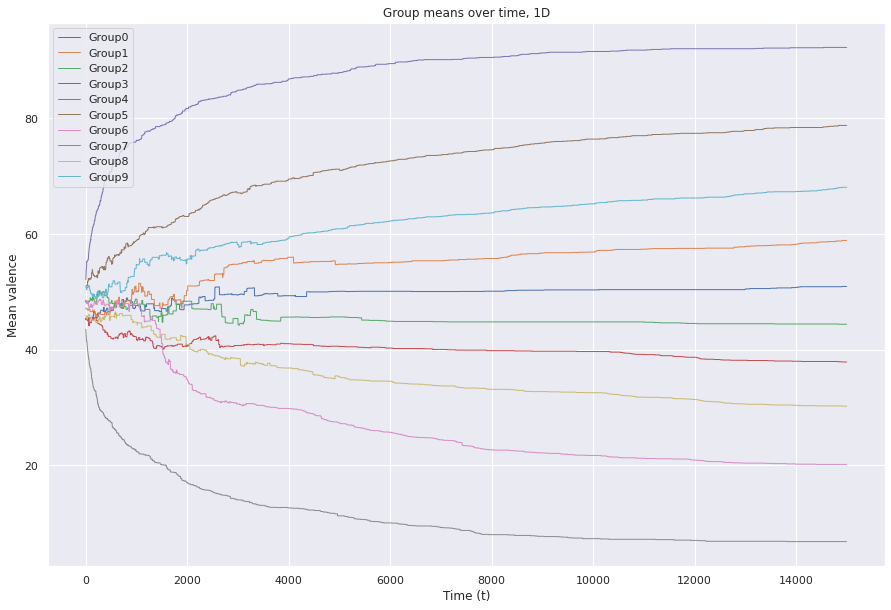

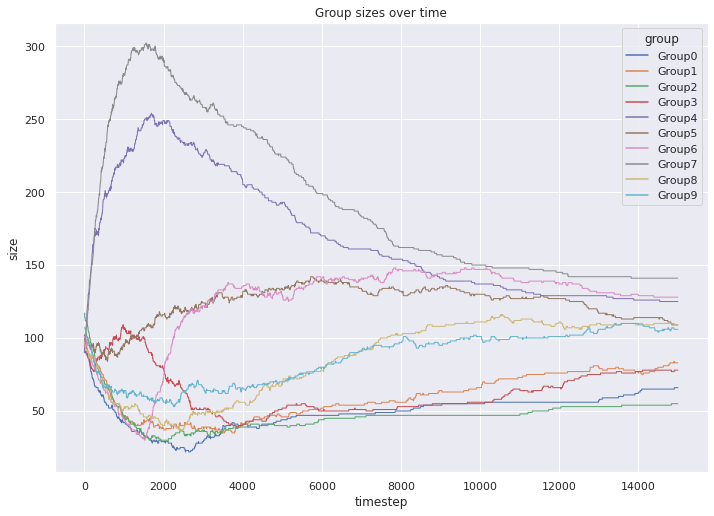

In [ ]:
testSimBasic.plotTimelineMeans()
testSimBasic.plotTimelineSizes()

Plotting timespan from 0 to 15000...


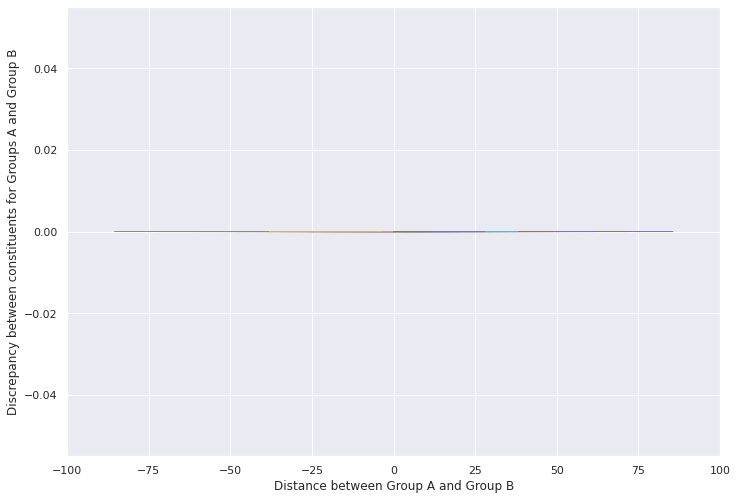

Plotting timespan from 0 to 15000...


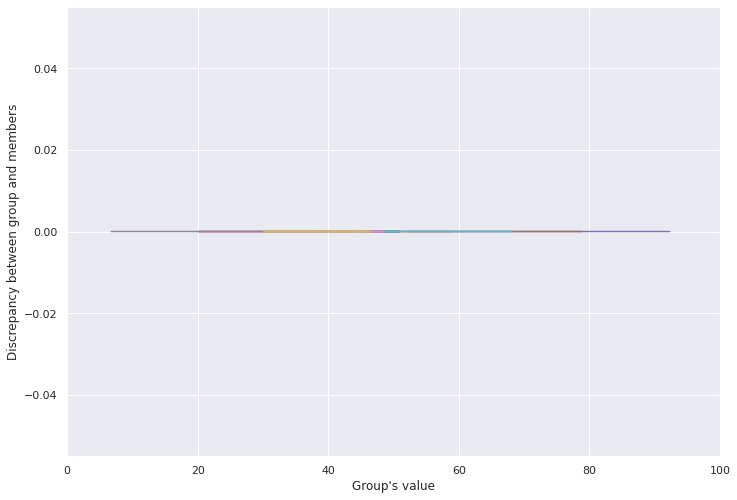

In [ ]:
testSimBasic.plotRMC(legend=False, timespan = [])
testSimBasic.plotRMCsimple(legend=False, timespan = [])

## Model 10 Repulsion and attraction

What is the hypothesis of this model?
* H1: As distance between groups decreases, unsorting increases.
 * Interpretation: Groups push against each other causing

In [ ]:
num_nodes = 1000
num_groups = 2
timesteps = 5000

asdf = np.linspace(1,100,num=timesteps)

group_function_parameters = {'rWidth': 100,
                             'rAmp' : 1,
                             'aWidth' : 500,
                             'aAmp' : 1}

testSim = GroupshiftSim(groupshift_function = groupshiftRepulseAttract,
                        indivchoice_function = oneNodeOpenSwitch,
                        groupFargs = group_function_parameters,
                        save_timesteps=list(range(0,timesteps,100)))

In [ ]:
#Random, normal, or sorted
testSim.initializeNodes(num_nodes, num_groups, 'random')
testSim.runSimulation(timesteps)

100%|██████████| 5000/5000 [01:19<00:00, 63.09it/s]


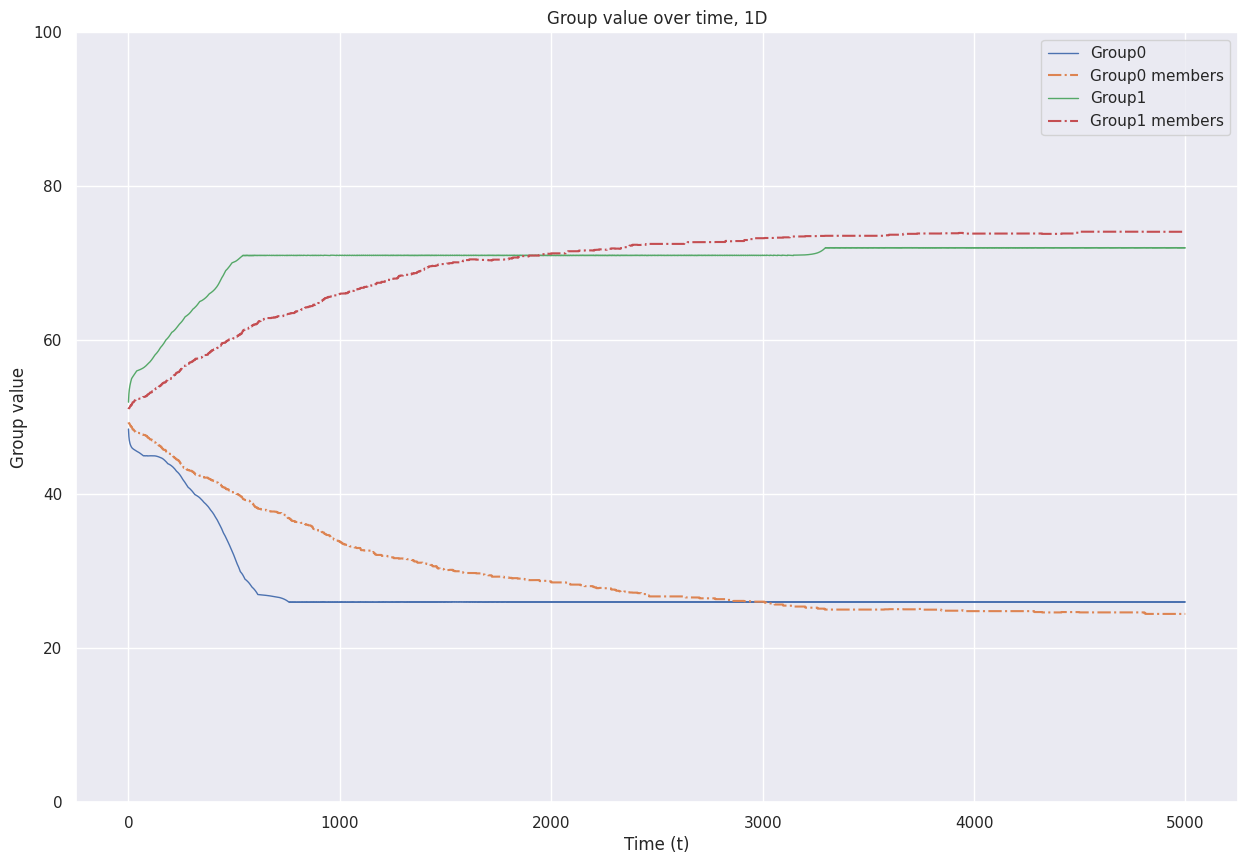

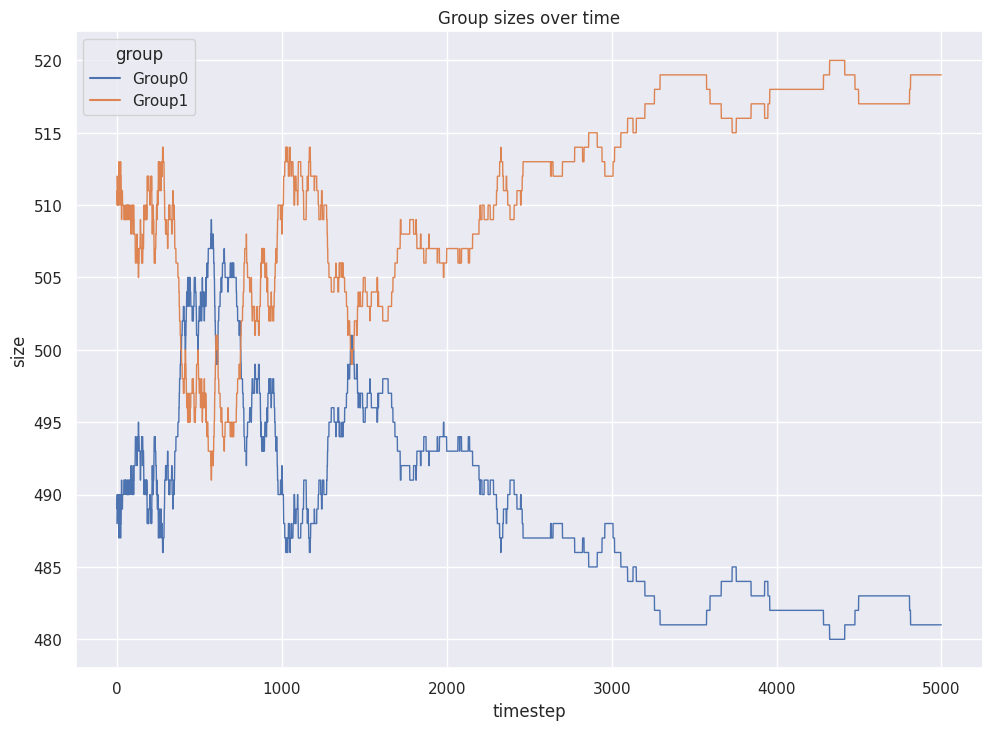

Plotting timespan from 0 to 5000...


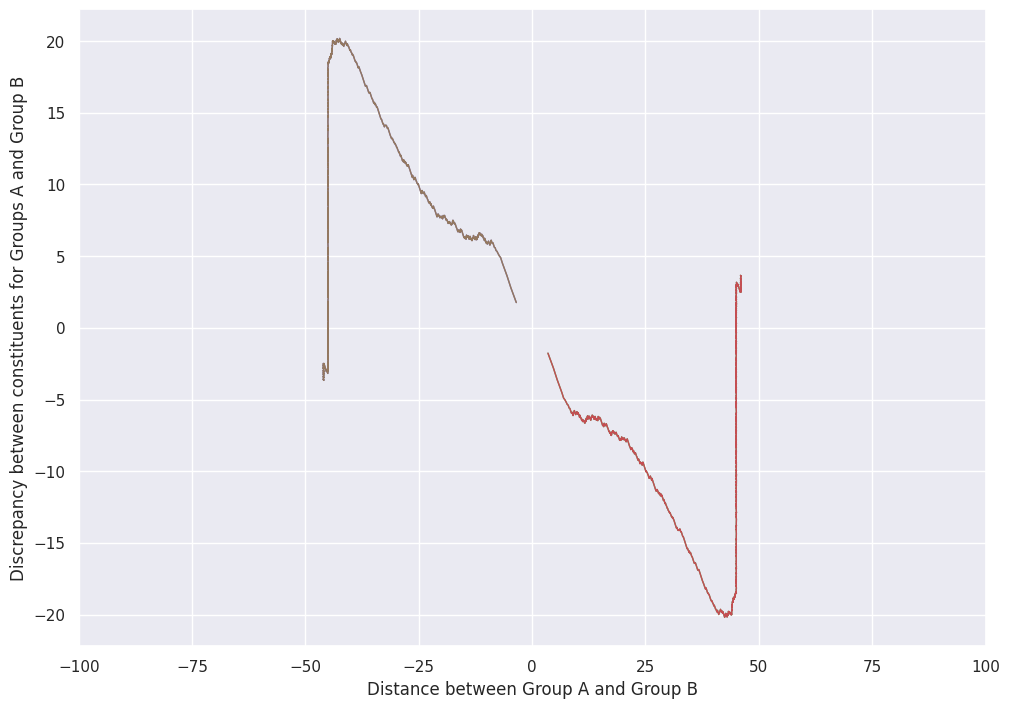

Plotting timespan from 0 to 5000...


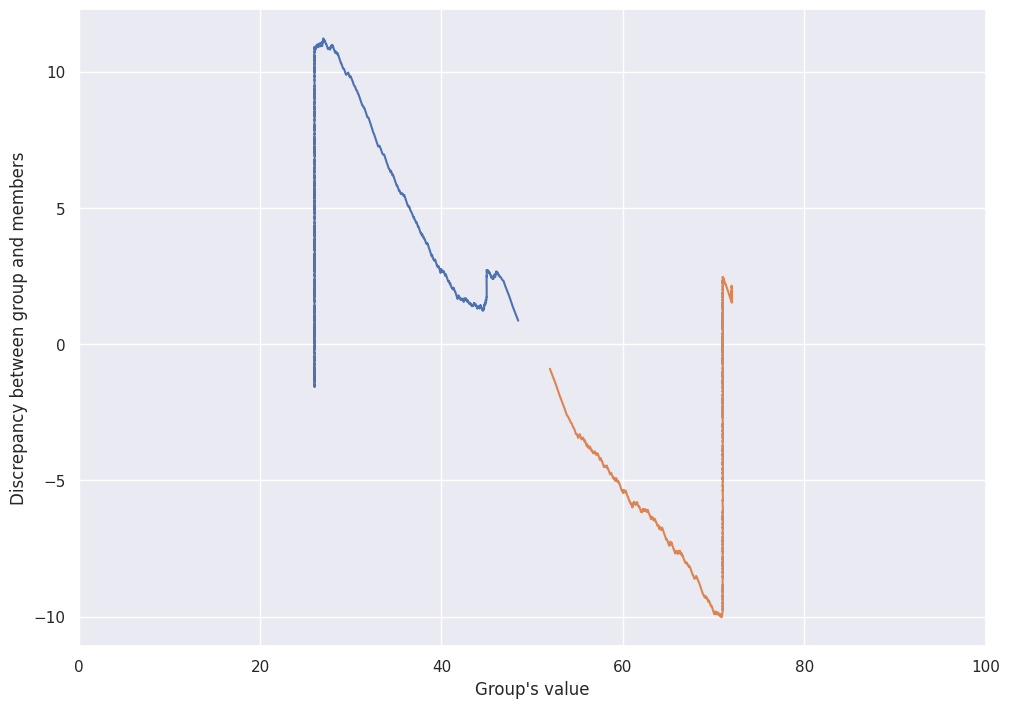

In [ ]:
testSim.plotTimelineMeans(legend=True)
testSim.plotTimelineSizes(legend=True)
plt.show()
#testSim.plotDistSwap(legend=False)
testSim.plotRMC(legend=True, timespan = [])#, scattersize = 20)
testSim.plotRMCsimple(legend=True, timespan = [])

Initial


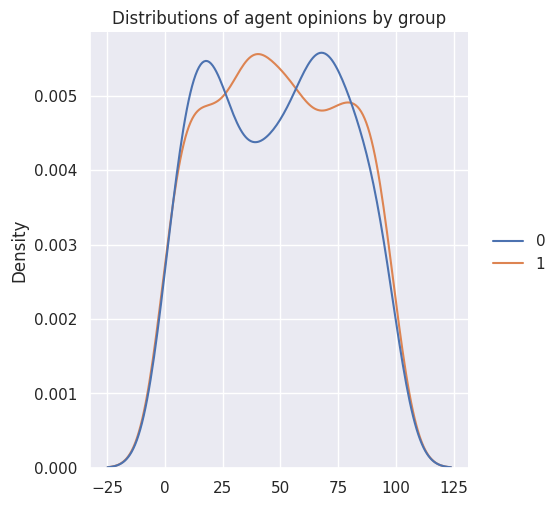

t=500


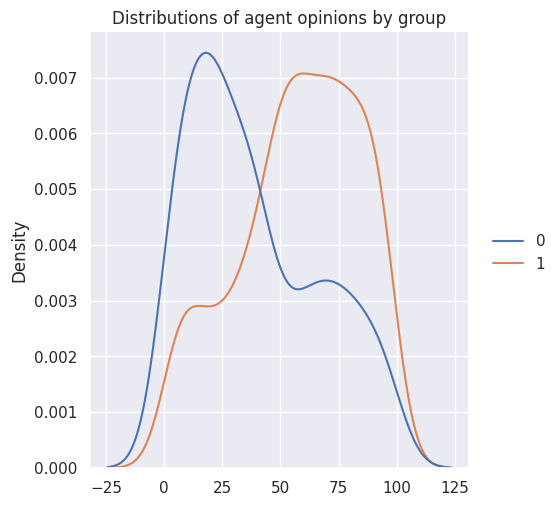

t=1000


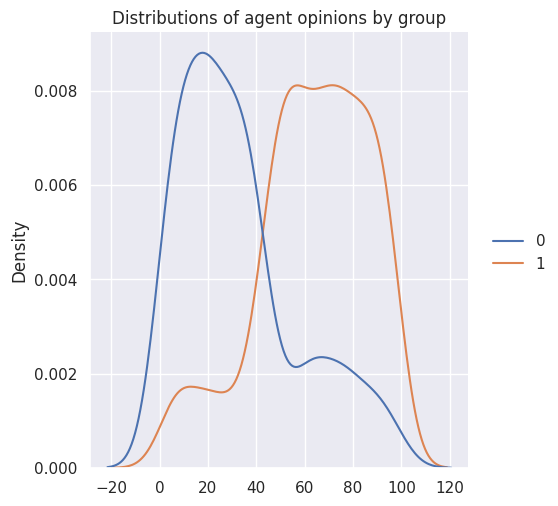

t=2000


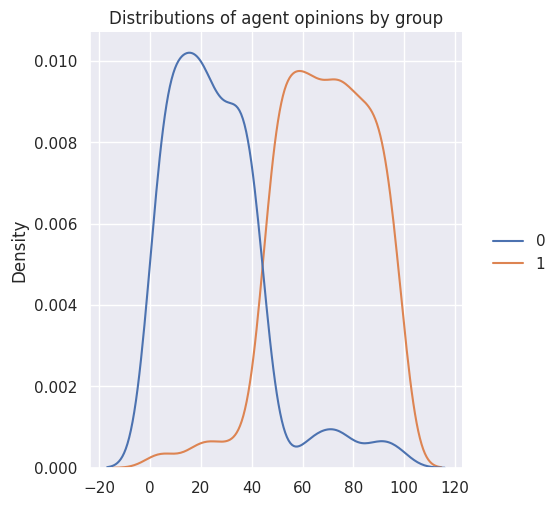

Final


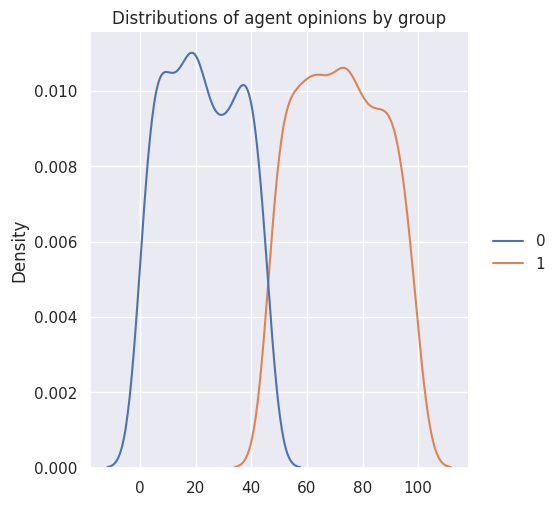

In [ ]:
print("Initial")
testSim.plotIndivDist(t = 0, overall = False)
plt.show()

print("t=500")
testSim.plotIndivDist(t = 500, overall = False)
plt.show()

print("t=1000")
testSim.plotIndivDist(t = 1000, overall = False)
plt.show()

print("t=2000")
testSim.plotIndivDist(t = 2000, overall = False)
plt.show()

print("Final")
testSim.plotIndivDist(t = 'now', overall = False)
plt.show()

Plotting timespan from 0 to 10000...


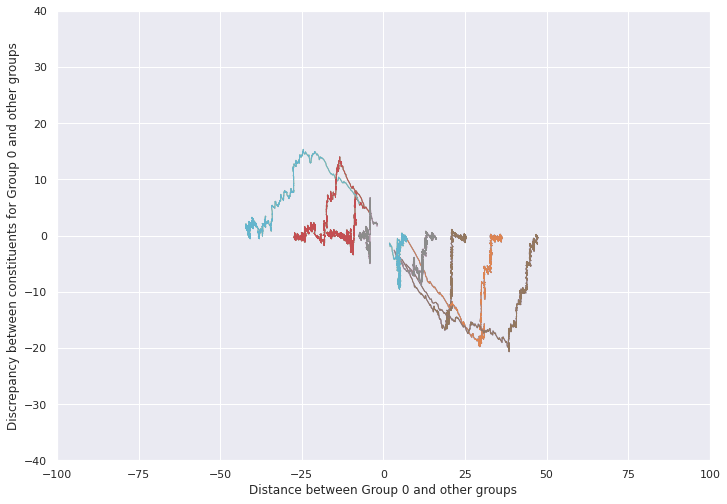

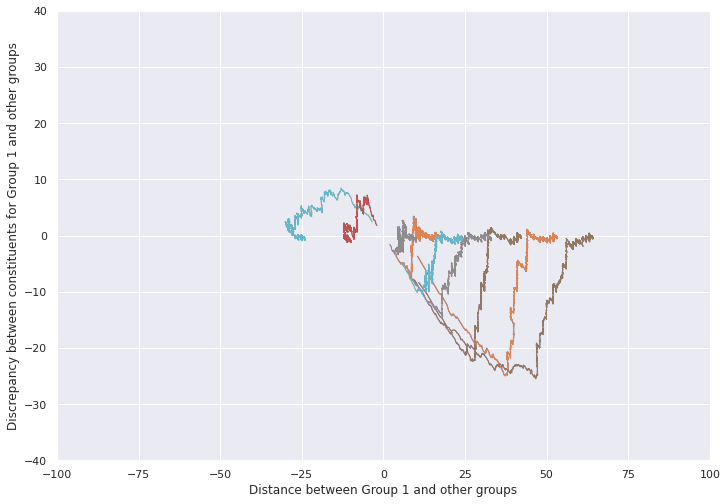

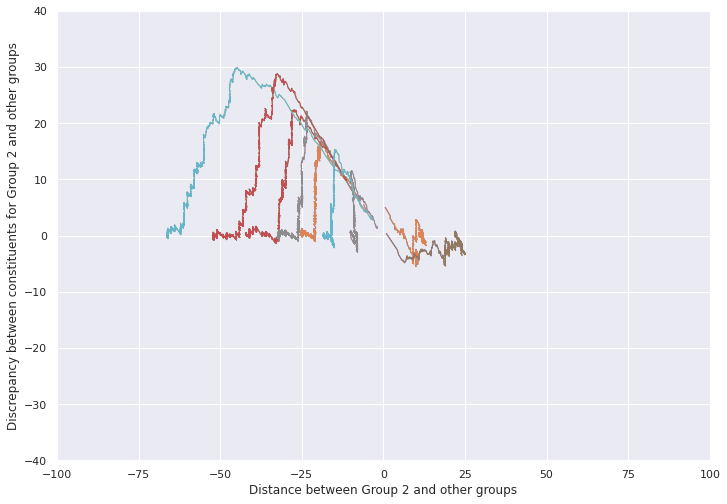

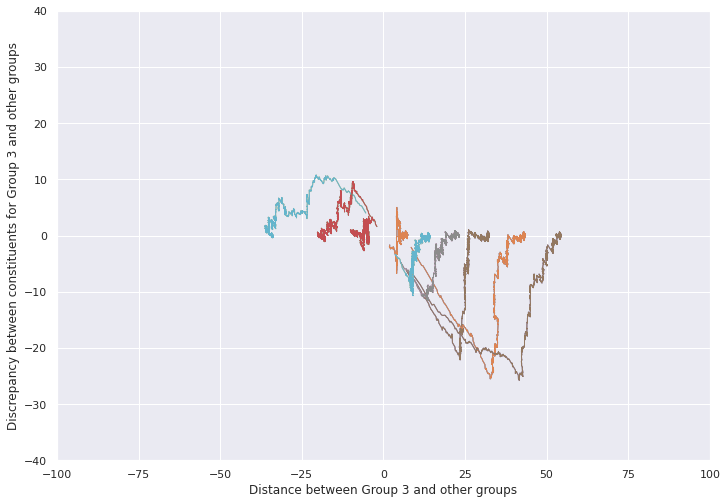

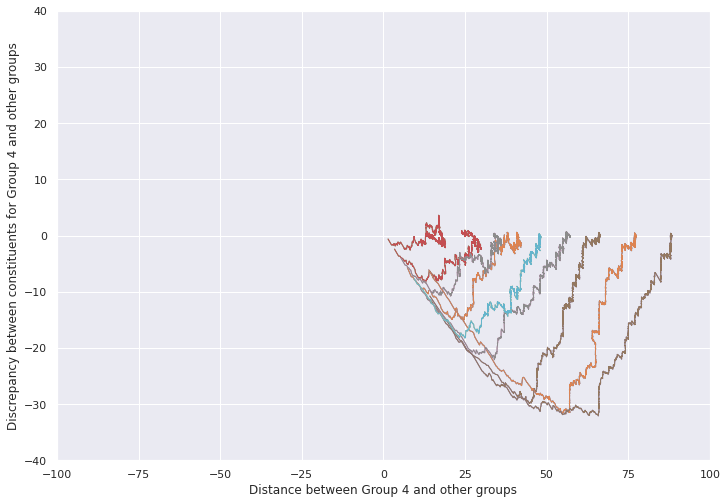

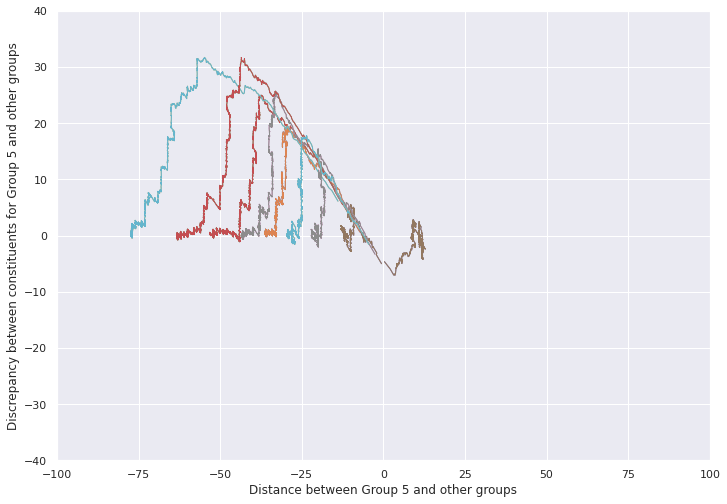

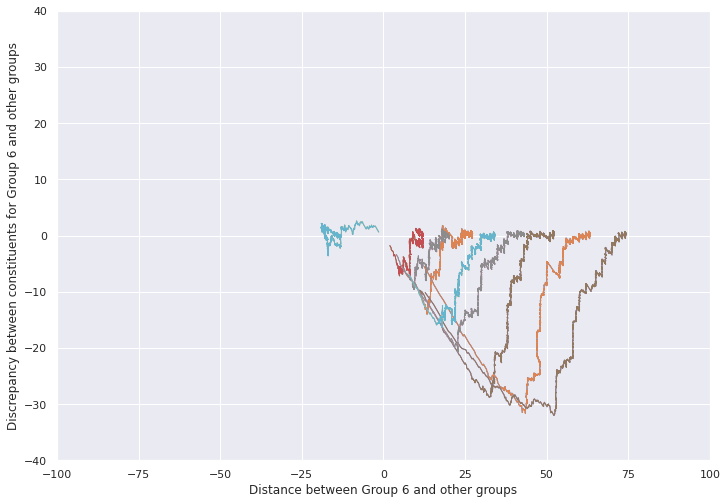

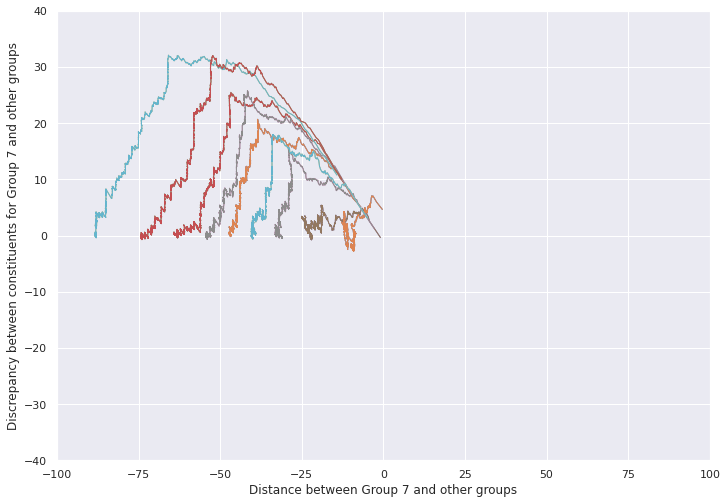

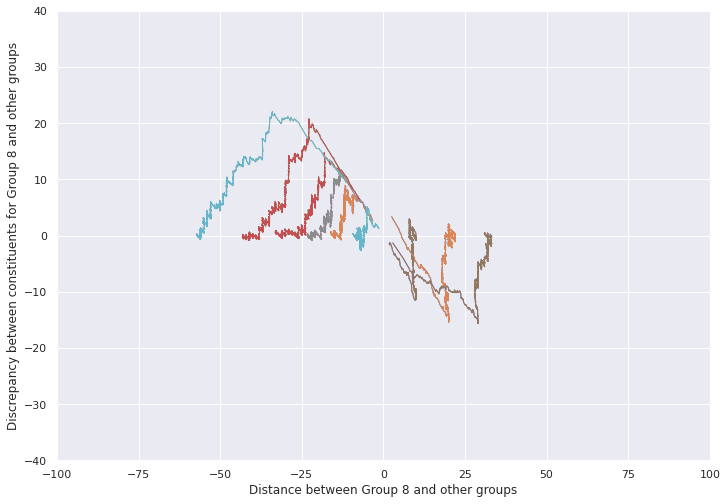

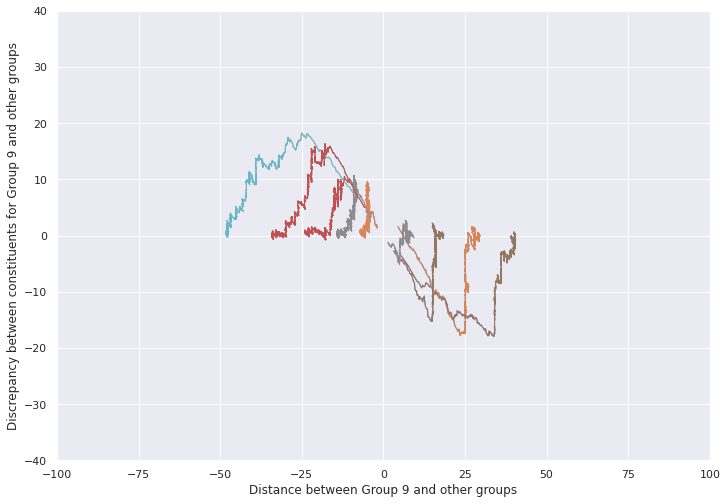

In [ ]:
testSim.plotRMC(legend=True, ylimits = [-40,40], timespan = [], individual_plots=True)
#Try and then specify other ylimits
#Individual_plots needs scattersize <--not going to fix this for now, 3/19/23

## Model 11 Timelag in individual perceptions

In [ ]:
def nodeSwitchByPerception(self, public_info):
  #Randomly select a node
  thisnode = np.random.choice(self.nodelist)

  if 'perception' not in self.g.nodes[thisnode]:
    #Check if 'perception' is in any other node
    perception_in_only_some_nodes = []
    for node in self.g.nodes():
      if 'perception' in self.g.nodes[node]:
        perception_in_only_some_nodes.append(True)
      else:
        perception_in_only_some_nodes.append(False)

    if True in perception_in_only_some_nodes and False in perception_in_only_some_nodes:
      raise Exception("Issue checking and assigning initial perception values for individual nodes. For some reason, only some but not all nodes have been given a perception value.")

    #Give every node in the network a perception value
    if True not in perception_in_only_some_nodes and False in perception_in_only_some_nodes:
      for i in self.nodelist:
        self.g.nodes[i]['perception'] = deepcopy(public_info) #This should only happen once

  #Calculate distances (for colors)
  dists = {}
  for i in self.g.nodes[thisnode]['perception']:
    dists[i] = np.linalg.norm(self.g.nodes[thisnode]['perception'][i] - self.g.nodes[thisnode]['valence'])
  #Get the group with the minimum distance
  mingroup = min(dists,key=dists.get)
  #Replace current group edge
  currentgroup = list(self.g.neighbors(thisnode))[0]
  if currentgroup != mingroup:
    self.g.remove_edge(thisnode,currentgroup)
    self.g.add_edge(thisnode,mingroup)

  #Update the individual's perception of that group
  self.g.nodes[thisnode]['perception'][mingroup] = deepcopy(public_info[mingroup])


In [ ]:
num_nodes = 1000
num_groups = 2
timesteps = 10000

asdf = np.linspace(1,100,num=timesteps)

group_function_parameters = {'rWidth': 200,
                             'rAmp' : 1,
                             'aWidth' : 500,
                             'aAmp' : 1}

testSim = GroupshiftSim(groupshift_function = groupshiftRepulseAttract,
                        indivchoice_function = nodeSwitchByPerception,
                        groupFargs = group_function_parameters,
                        save_timesteps=list(range(0,timesteps,100)))

In [ ]:
#Random, normal, or sorted
testSim.initializeNodes(num_nodes, num_groups, 'random')
testSim.runSimulation(timesteps)

100%|██████████| 10000/10000 [01:48<00:00, 91.90it/s]


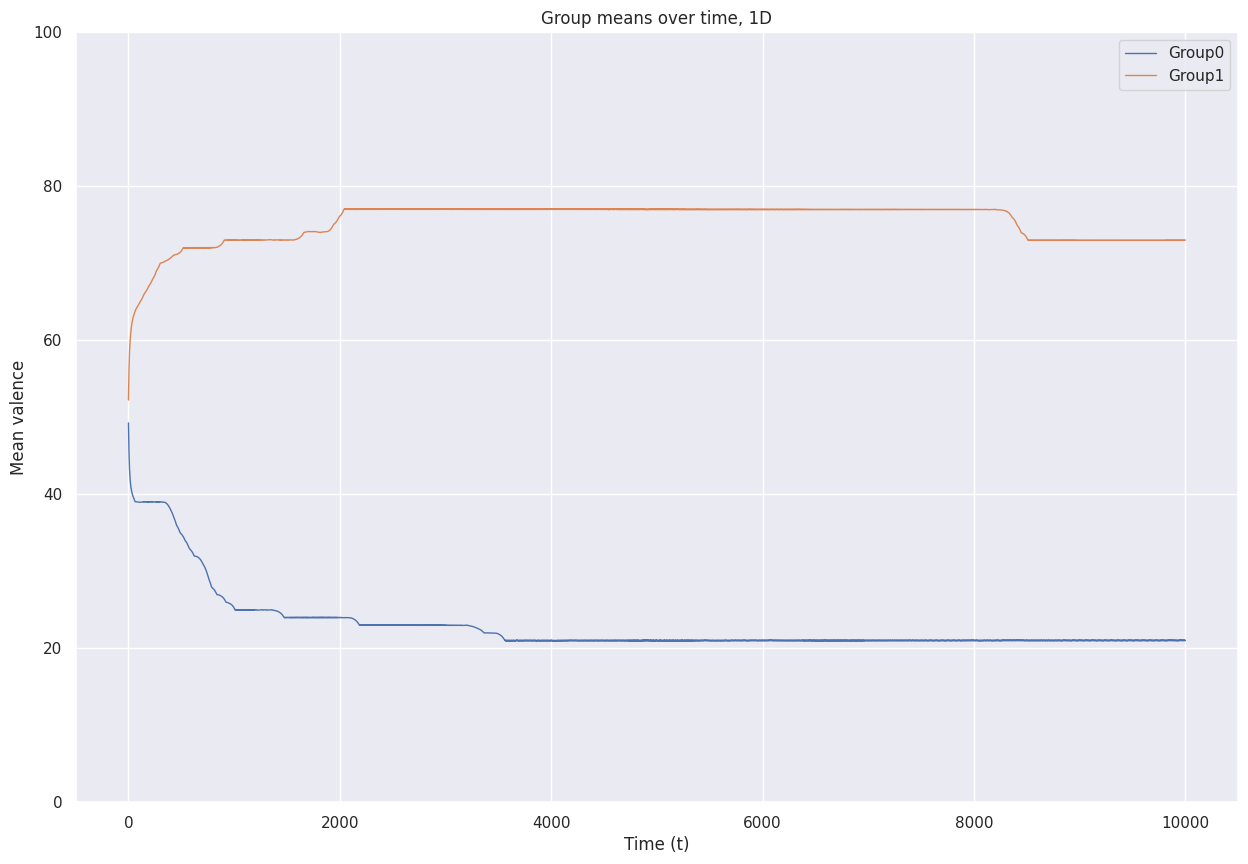

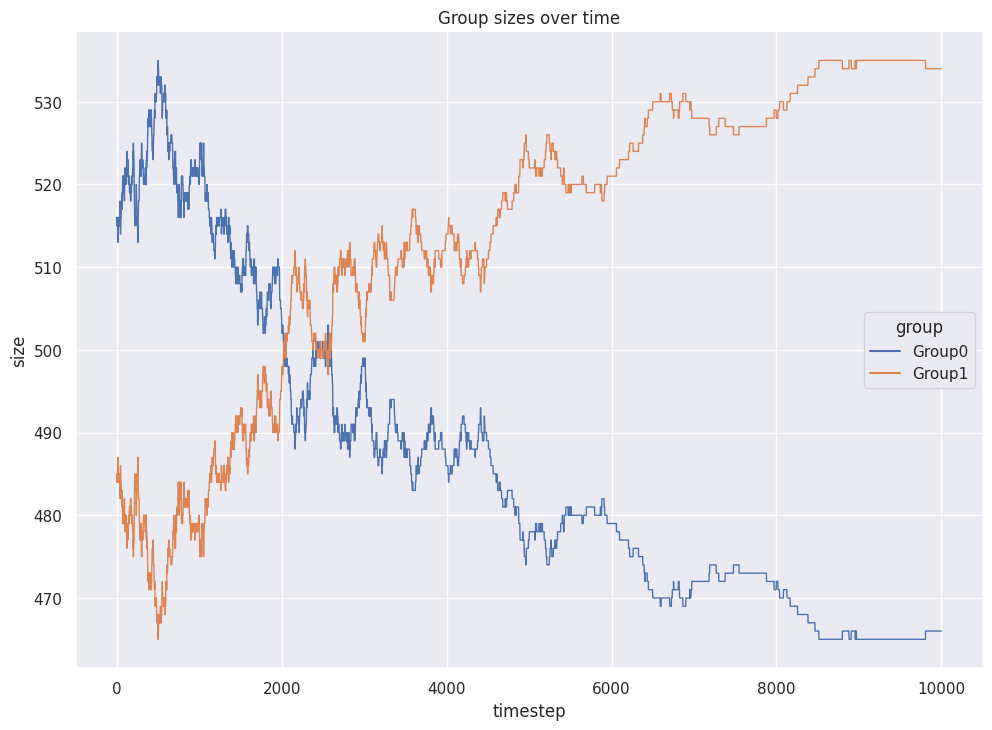

Plotting timespan from 0 to 10000...


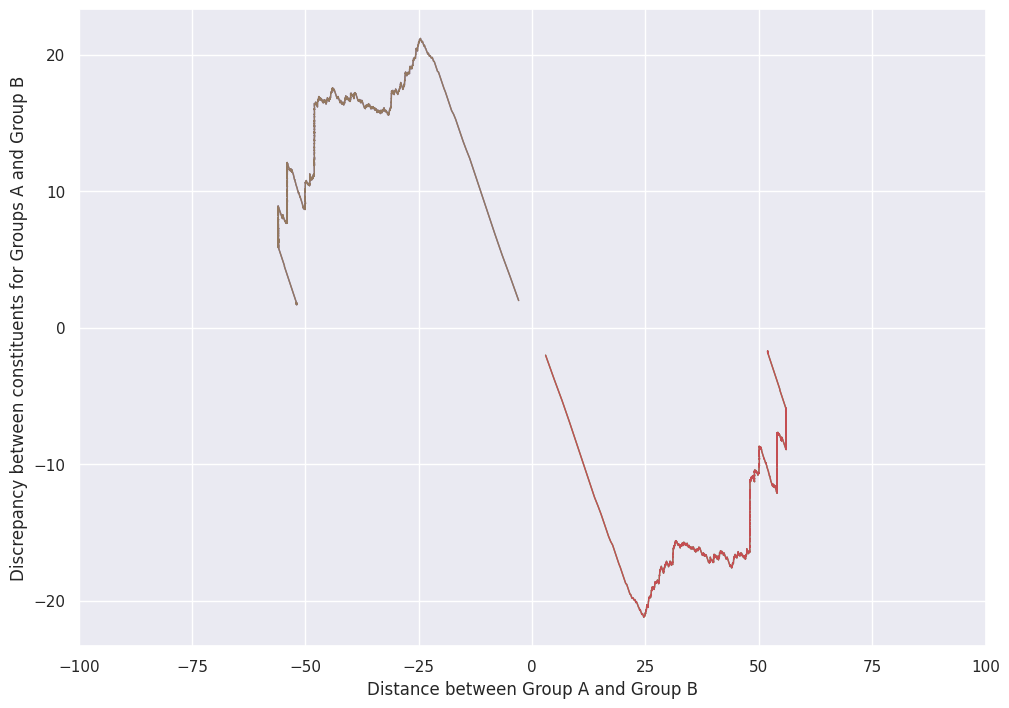

Plotting timespan from 0 to 10000...


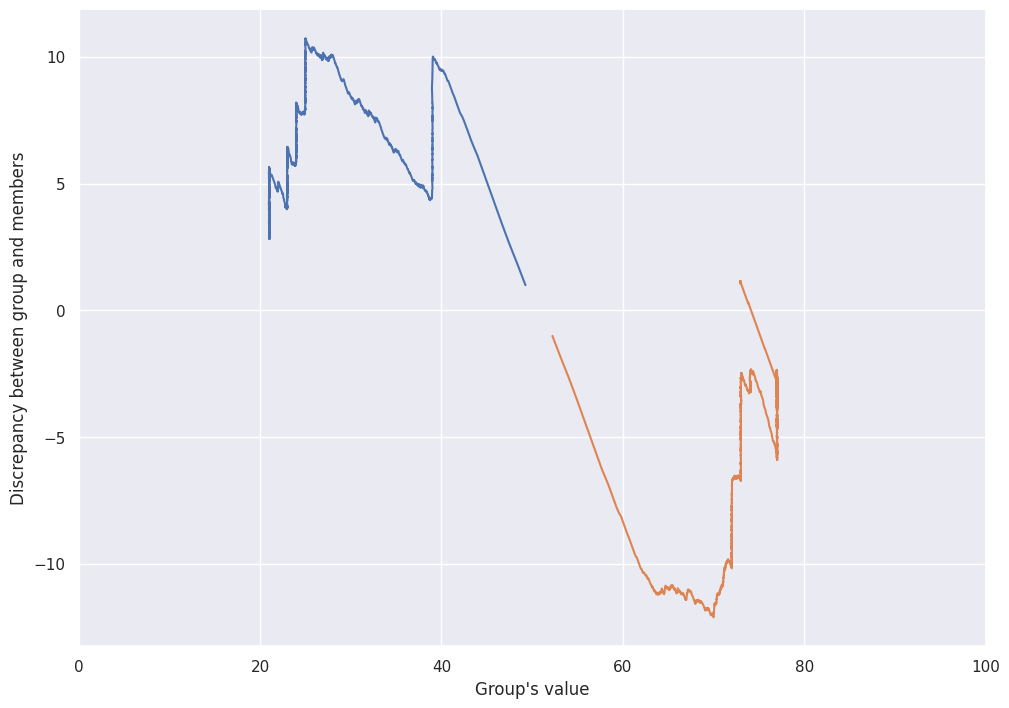

In [ ]:
testSim.plotTimelineMeans(legend=True)
testSim.plotTimelineSizes(legend=True)
plt.show()

testSim.plotRMC(legend=True, timespan = [])#, scattersize = 20)
testSim.plotRMCsimple(legend=True, timespan = [])

Initial


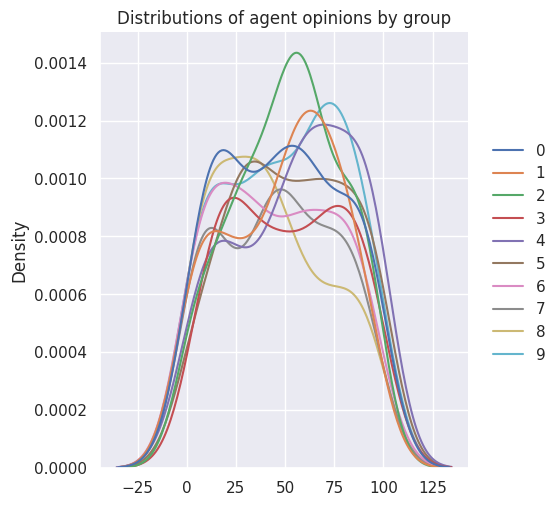

t=500


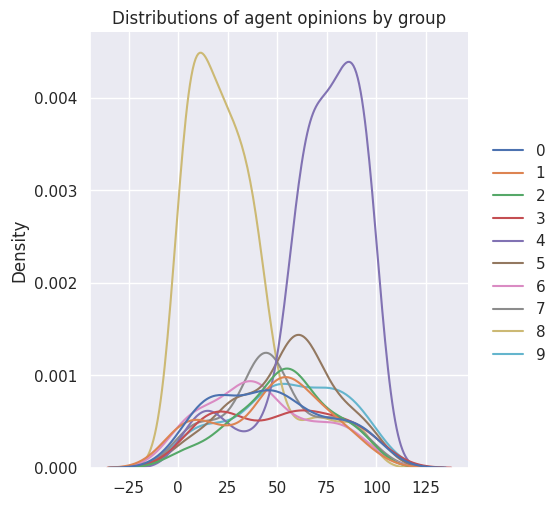

t=1000


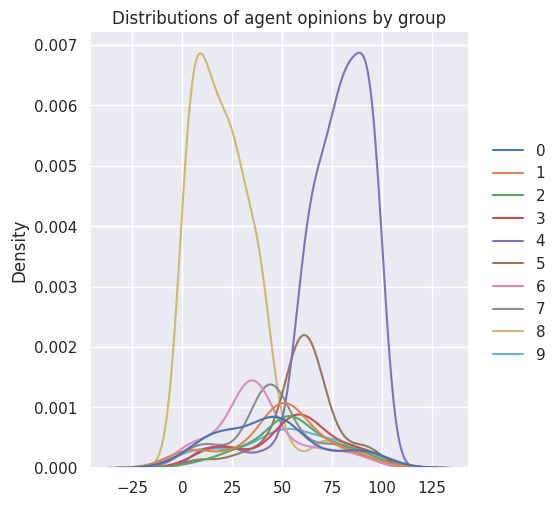

t=2000


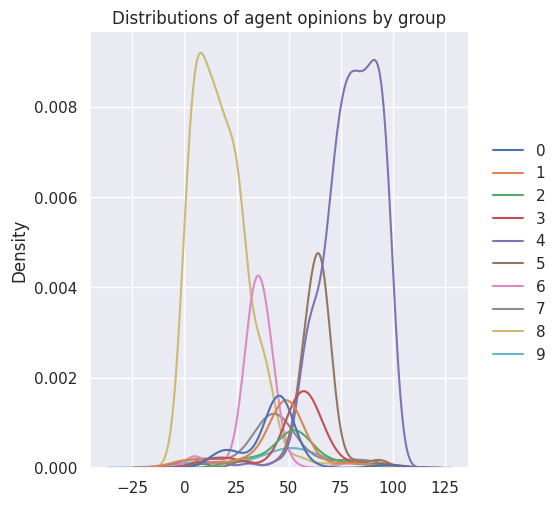

Final


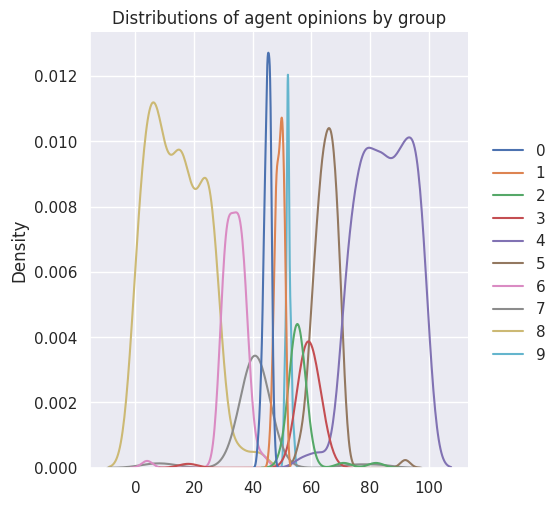

In [ ]:
print("Initial")
testSim.plotIndivDist(t = 0, overall = False)
plt.show()

print("t=500")
testSim.plotIndivDist(t = 500, overall = False)
plt.show()

print("t=1000")
testSim.plotIndivDist(t = 1000, overall = False)
plt.show()

print("t=2000")
testSim.plotIndivDist(t = 2000, overall = False)
plt.show()

print("Final")
testSim.plotIndivDist(t = 'now', overall = False)
plt.show()

## Model 12 Testing efficient process

### Basic setup

In [ ]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import time
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")
import functools
from copy import deepcopy
import itertools
import warnings

In [ ]:
num_nodes = 1000
num_groups = 2
timesteps = 10000
dims = 1

# aAmp = 1.0
# aWidth = 250.0
# rAmp = 1.0
# rWidth = 20

#=======================================================
# Initial state
#=======================================================

#   Node opinion matrix
N = np.random.randint(0,100,size=(num_nodes,dims))

#   N_adj matrix
N_adj = np.zeros((num_nodes, timesteps))
N_adj[:,0] = np.random.randint(0,num_groups,size=(1000))

#=======================================================
# Simulation-relevant instantiation
#=======================================================

# List out who will flip, in order
flip_order = np.random.randint(0,num_nodes,size=(timesteps))

#INSTANTIATE INITIAL GROUP VALUES
G = np.zeros((num_groups,dims, timesteps))
sums = np.zeros((num_groups, dims)) # Calculate the sum of node values for each group
np.add.at(sums, N_adj[:, 0].astype(int), N)
counts = np.bincount(N_adj[:, 0].astype(int), minlength=num_groups) # Calculate the number of nodes in each group
counts[counts == 0] = 1 # Avoid division by zero by replacing zero counts with one # (the corresponding sums are zero, so the division result will still be zero)
G[:,:,0] = sums / counts[:, np.newaxis] # Calculate the mean of node values for each group

#=======================================================
# Simulation functions
#=======================================================

def switch_group(t, N, G, flip_order, N_adj):
    # Take assignments from the previous timestep for all nodes
    N_adj[:, t] = N_adj[:, t-1]

    # Node to be updated
    node_idx = flip_order[t]
    node_values = N[node_idx]

    # Compute distances of this node to all group centroids from the previous timestep
    distances = np.linalg.norm(node_values - G[:, :, t-1], axis=1)

    # Find the closest group
    closest_group = np.argmin(distances)

    # Update group assignment for this node
    N_adj[node_idx, t] = closest_group

def update_group_values_to_mean(G, N, N_adj, t):
    # For each group
    for i in range(G.shape[0]):
        # Find the individuals in the group at the given timestep
        members_idx = np.where(N_adj[:, t] == i)[0]

        # Calculate the mean value for these individuals
        group_mean = np.mean(N[members_idx], axis=0)

        # Set the group value to this mean
        G[i, :, t] = group_mean

def attract(G, N, N_adj, t, amp, width, lowvalence=0, highvalence=100):
    effects = np.zeros_like(G[:, :, t])

    # For each group
    for i in range(G.shape[0]):
        # Get member valences/opinions for the current timestep
        members_idx = np.where(N_adj[:, t] == i)[0]
        membervalences = N[members_idx]

        # Compute the distances & update based on the previous group's opinion
        op = G[i, :, t-1]
        pointing = np.sign(membervalences - op)
        distance = np.abs(membervalences - op)
        delta_op = pointing * amp * np.exp(-1 * (1/width) * distance) * (1/len(members_idx))

        # Sum the changes and apply bounds
        effects[i] = delta_op.sum(axis=0)

    return effects

def repulse(G, t, amp, width, lowvalence=0, highvalence=100):
    effects = np.zeros_like(G[:, :, t])
    # For each group
    for i in range(G.shape[0]):
        # Calculate repulsion from all other groups based on the previous group's opinion
        op = G[i, :, t-1]
        aggregated_delta = np.zeros(op.shape)

        for j in range(G.shape[0]):
            if i != j:  # We don't want self-repulsion
                pointing = -np.sign(G[j, :, t-1] - op)
                distance = np.abs(G[j, :, t-1] - op)
                delta_op = pointing * amp * np.exp(-1 * (1/width) * distance)

                # Accumulate the changes for the current group
                aggregated_delta += delta_op

        # Update the group opinion using the accumulated repulsion effects and enforce bounds
        effects[i] = aggregated_delta

    return effects

def repulseAttract(G, N, N_adj, t, amp_a, width_a, amp_r, width_r,
                  lowvalence=0, highvalence=100,
                  use_attraction=True, use_repulsion=True):
    total_effects = np.zeros_like(G[:, :, t])

    if use_attraction:
        attraction_effects = attract(G, N, N_adj, t, amp_a, width_a)
        total_effects += attraction_effects

    if use_repulsion:
        repulsion_effects = repulse(G, t, amp_r, width_r)
        total_effects += repulsion_effects

    new_opinions = G[:, :, t-1] + total_effects
    G[:, :, t] = np.clip(new_opinions, lowvalence, highvalence)

#=======================================================
# Plot group means
#=======================================================

def plot_group_values(G, N, N_adj, dims, lowvalence=0, highvalence=100):
    # Create a figure and axis
    fig, ax = plt.subplots(dims, figsize=(10, 5 * dims))

    # If there's only one dimension, make ax an array for consistency
    if dims == 1:
        ax = [ax]

    # For each dimension
    for d in range(dims):
        # Plot the group value for each group in the current dimension over time
        for group in range(G.shape[0]):
            ax[d].plot(G[group, d, :], label=f'Group {group}')

            # Calculate and plot the mean opinion of the constituents for the current group over time
            mean_opinions = []
            for t in range(G.shape[2]):
                group_members = N[N_adj[:, t] == group]
                mean_opinion = np.mean(group_members[:, d])
                mean_opinions.append(mean_opinion)
            ax[d].plot(mean_opinions, 'r-.', label=f'Mean Opinion Group {group}')

        ax[d].set_title(f'Dimension {d + 1}')
        ax[d].set_xlabel('Time')
        ax[d].set_ylabel('Value')
        ax[d].legend()
        ax[d].set_ylim((lowvalence,highvalence))

    plt.tight_layout()
    plt.show()

In [ ]:
aAmp = 1.0
aWidth = 250.0
rAmp = 1.0
rWidth = 50

for t in tqdm(range(1,timesteps)):
  switch_group(t, N, G, flip_order, N_adj)
  repulseAttract(G, N, N_adj, t, aAmp, aWidth, rAmp, rWidth, use_repulsion = True)

100%|██████████| 9999/9999 [00:03<00:00, 3155.06it/s]


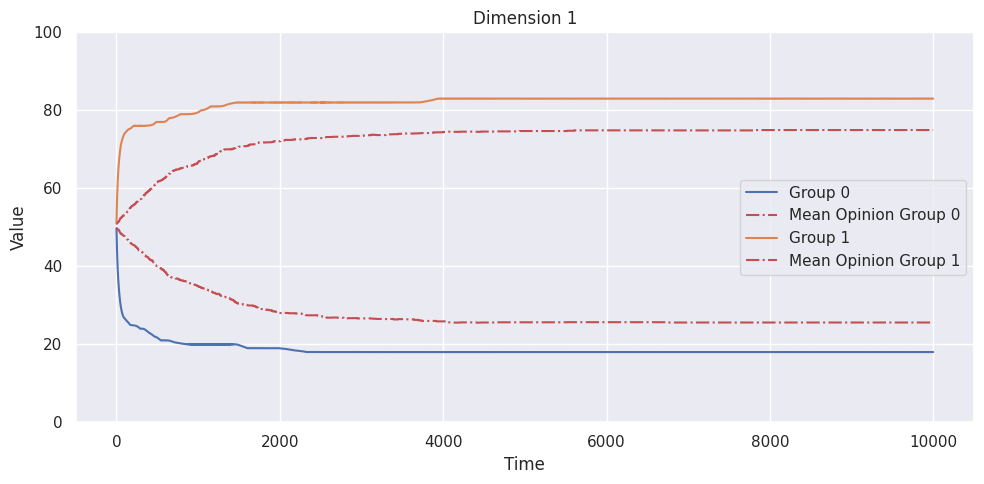

In [ ]:
plot_group_values(G, N, N_adj, dims)

## Model 12 Encapsulation

### Class implementation

In [ ]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import h5py

In [ ]:
class GroupshiftSim():

  def __init__(self, G, N, N_adj, lowvalence, highvalence, aWidth, rWidth):
    self.G = G
    self.N = N
    self.N_adj = N_adj
    self.lowvalence = lowvalence
    self.highvalence = highvalence
    self.aWidth = aWidth
    self.rWidth = rWidth

    #Pull out num_nodes, num_groups, and dims from the arrays
    self.num_nodes, self.dims = N.shape
    self.num_groups, _, self.timesteps = G.shape

    # List out who will flip, in order
    self.flip_order = np.random.randint(0,num_nodes,size=(timesteps))

    #Other business
    self.initialize_G()

  def initialize_G(self):
    #INSTANTIATE INITIAL GROUP VALUES
    sums = np.zeros((self.num_groups, self.dims)) # Calculate the sum of node values for each group
    np.add.at(sums, self.N_adj[:, 0].astype(int), self.N)
    counts = np.bincount(self.N_adj[:, 0].astype(int), minlength=self.num_groups) # Calculate the number of nodes in each group
    counts[counts == 0] = 1 # Avoid division by zero by replacing zero counts with one # (the corresponding sums are zero, so the division result will still be zero)
    self.G[:,:,0] = sums / counts[:, np.newaxis] # Calculate the mean of node values for each group

#=======================================================
# Simulation functions
#=======================================================

  def runSimulation(self):
    for t in tqdm(range(1,self.timesteps)):
      self.switch_group(t)
      self.repulseAttract(t)

  def switch_group(self, t):
      # Take assignments from the previous timestep for all nodes
      self.N_adj[:, t] = self.N_adj[:, t-1]

      # Node to be updated
      node_idx = self.flip_order[t]
      node_values = self.N[node_idx]

      # Compute distances of this node to all group centroids from the previous timestep
      distances = np.linalg.norm(node_values - self.G[:, :, t-1], axis=1)

      # Find the closest group
      closest_group = np.argmin(distances)

      # Update group assignment for this node
      self.N_adj[node_idx, t] = closest_group

  def update_group_values_to_mean(self, t):
      # For each group
      for i in range(self.G.shape[0]):
          # Find the individuals in the group at the given timestep
          members_idx = np.where(self.N_adj[:, t] == i)[0]

          # Calculate the mean value for these individuals
          group_mean = np.mean(self.N[members_idx], axis=0)

          # Set the group value to this mean
          self.G[i, :, t] = group_mean

  def attract(self, t):
      effects = np.zeros_like(self.G[:, :, t])

      # For each group
      for i in range(self.G.shape[0]):
          # Get member valences/opinions for the current timestep
          members_idx = np.where(self.N_adj[:, t] == i)[0]
          membervalences = self.N[members_idx]

          # Compute the distances & update based on the previous group's opinion
          op = self.G[i, :, t-1]
          pointing = np.sign(membervalences - op)
          distance = np.abs(membervalences - op)
          delta_op = pointing * np.exp(-1 * (1/self.aWidth) * distance) * (1/len(members_idx))

          # Sum the changes and apply bounds
          effects[i] = delta_op.sum(axis=0)

      return effects

  def repulse(self, t):
      effects = np.zeros_like(self.G[:, :, t])
      # For each group
      for i in range(self.G.shape[0]):
          # Calculate repulsion from all other groups based on the previous group's opinion
          op = self.G[i, :, t-1]
          aggregated_delta = np.zeros(op.shape)

          for j in range(self.G.shape[0]):
              if i != j:  # We don't want self-repulsion
                  pointing = -np.sign(self.G[j, :, t-1] - op)
                  distance = np.abs(self.G[j, :, t-1] - op)
                  delta_op = pointing * np.exp(-1 * (1/self.rWidth) * distance)

                  # Accumulate the changes for the current group
                  aggregated_delta += delta_op

          # Update the group opinion using the accumulated repulsion effects and enforce bounds
          effects[i] = aggregated_delta

      return effects

  def repulseAttract(self, t, use_attraction=True, use_repulsion=True):
      total_effects = np.zeros_like(self.G[:, :, t])

      if use_attraction:
          attraction_effects = self.attract(t)
          total_effects += attraction_effects

      if use_repulsion:
          repulsion_effects = self.repulse(t)
          total_effects += repulsion_effects

      new_opinions = self.G[:, :, t-1] + total_effects
      self.G[:, :, t] = np.clip(new_opinions, self.lowvalence, self.highvalence)

#=======================================================
# Plotting functions
#=======================================================

  def plot_group_values(self):
      # Create a figure and axis
      fig, ax = plt.subplots(self.dims, figsize=(10, 5 * self.dims))

      # If there's only one dimension, make ax an array for consistency
      if self.dims == 1:
          ax = [ax]

      # For each dimension
      for d in range(self.dims):
          # Plot the group value for each group in the current dimension over time
          for group in range(self.G.shape[0]):
              ax[d].plot(self.G[group, d, :], label=f'Group {group}')

              # Calculate and plot the mean opinion of the constituents for the current group over time
              mean_opinions = []
              for t in range(self.G.shape[2]):
                  group_members = self.N[self.N_adj[:, t] == group]
                  mean_opinion = np.mean(group_members[:, d])
                  mean_opinions.append(mean_opinion)
              ax[d].plot(mean_opinions, 'r-.', label=f'Mean Opinion Group {group}')

          ax[d].set_title(f'Dimension {d + 1}')
          ax[d].set_xlabel('Time')
          ax[d].set_ylabel('Value')
          ax[d].legend()
          ax[d].set_ylim((self.lowvalence,self.highvalence))

      plt.tight_layout()
      plt.show()

In [ ]:
num_nodes = 1000
num_groups = 3
timesteps = 10000
dims = 2
lowvalence = 0
highvalence = 100
aWidth = 50
rWidth = 7

#   Node opinion matrix
N = np.random.uniform(0, 100, size=(num_nodes, dims))

#   N_adj matrix
N_adj = np.zeros((num_nodes, timesteps))
N_adj[:,0] = np.random.randint(0,num_groups,size=(1000))

G = np.zeros((num_groups,dims, timesteps))

#=======================================================
# Initial state
#=======================================================

testSim = GroupshiftSim(G, N, N_adj, lowvalence, highvalence, aWidth, rWidth)
testSim.runSimulation()

100%|██████████| 9999/9999 [00:08<00:00, 1154.20it/s]


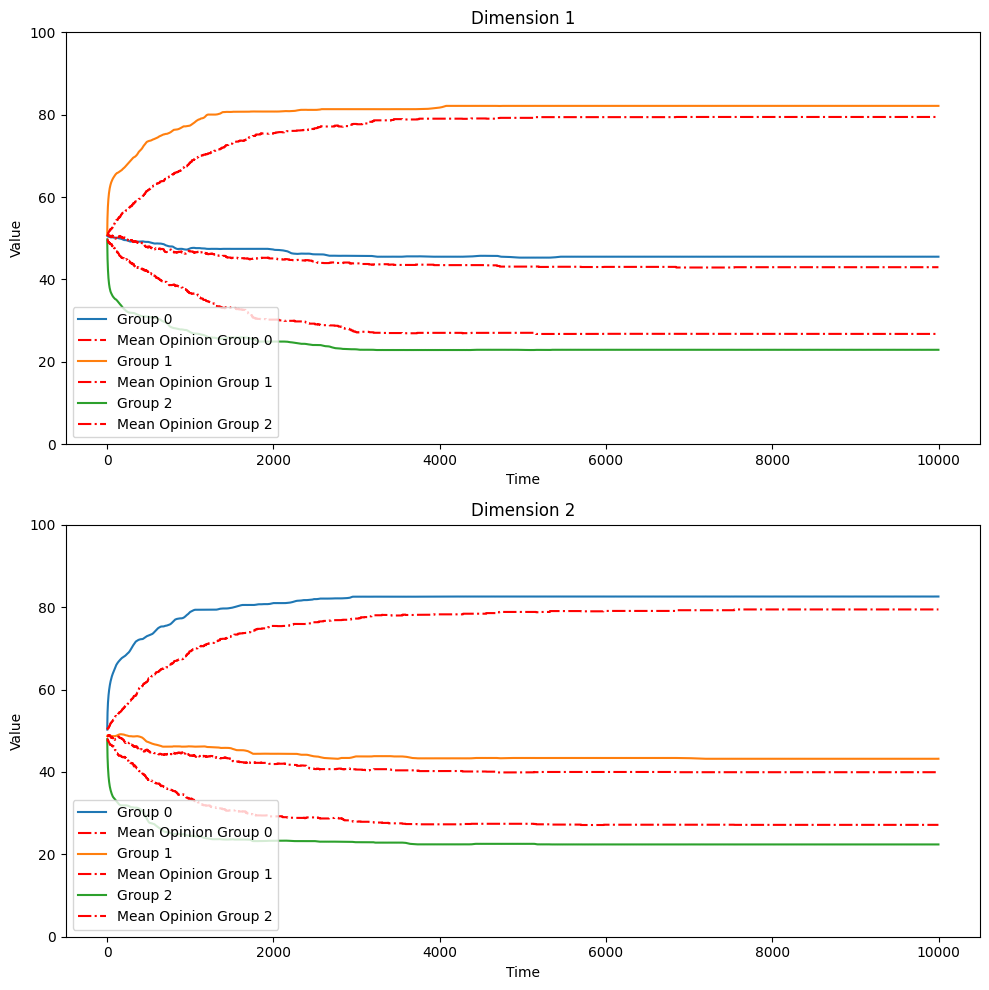

In [ ]:
testSim.plot_group_values()

### Parameter sweep

In [ ]:
def run_simulations_and_store(num_nodes, num_groups, timesteps, dims, lowvalence, highvalence, aWidthRange, rWidthRange):
    params_for_filename = '.'.join([str(x) for x in ['N',num_nodes, 'G',num_groups, 'T', timesteps, 'D', dims, 'LOW', lowvalence, 'HIGH', highvalence]])
    # Define the HDF5 file to store results
    with h5py.File('simulation_results_'+params_for_filename+'.hdf5', 'w') as f:
        # Loop through parameter space
        for aWidth in aWidthRange:
            for rWidth in rWidthRange:
                # Initialize data
                N = np.random.uniform(0, 100, size=(num_nodes, dims))
                N_adj = np.zeros((num_nodes, timesteps))
                N_adj[:, 0] = np.random.randint(0, num_groups, size=(1000))
                G = np.zeros((num_groups, dims, timesteps))

                # Run simulation
                sim = GroupshiftSim(G, N, N_adj, lowvalence, highvalence, aWidth, rWidth)
                sim.runSimulation()

                # Store results in HDF5
                grp_name = f"simulation_{aWidth:.2f}_{rWidth:.2f}"
                grp = f.create_group(grp_name)
                grp.create_dataset('G', data=sim.G)
                grp.create_dataset('N', data=sim.N)
                grp.create_dataset('N_adj', data=sim.N_adj)

def get_simulation_data(num_nodes, num_groups, timesteps, dims, lowvalence, highvalence, aWidth_value, rWidth_value):
    params_for_filename = '.'.join([str(x) for x in ['N',num_nodes, 'G',num_groups, 'T', timesteps, 'D', dims, 'LOW', lowvalence, 'HIGH', highvalence]])
    # Open the HDF5 file in read mode
    with h5py.File('simulation_results.hdf5', 'r') as hdf5_file:
        # Construct the group name based on the given parameters
        group_name = f'simulation_{aWidth_value:.2f}_{rWidth_value:.2f}'

        # Check if the group exists in the file
        if group_name in hdf5_file:
            # Extract datasets
            G_data = hdf5_file[group_name]['G'][:]
            N_data = hdf5_file[group_name]['N'][:]
            N_adj_data = hdf5_file[group_name]['N_adj'][:]
            return G_data, N_data, N_adj_data
        else:
            print(f"No simulations found for aWidth={aWidth_value} and rWidth={rWidth_value}")
            return None


In [ ]:
def calculate_group_constituent_differences(G, N, N_adj):
    # Initialize a matrix to hold the differences
    differences = np.zeros_like(G)

    # Iterate over each timestep
    for t in range(G.shape[2]):
        # For each group at this timestep
        for group in range(G.shape[0]):
            # Find indices of the members of this group
            member_indices = np.where(N_adj[:, t] == group)[0]

            # Calculate the mean opinion of group members
            if len(member_indices) > 0:  # Check if there are any members in the group
                mean_opinion = N[member_indices].mean(axis=0)
            else:
                # If there are no members in the group, there's no difference
                mean_opinion = np.zeros((G.shape[1],))

            # Calculate the difference between the group's opinion and the mean opinion of its members
            differences[group, :, t] = G[group, :, t] - mean_opinion

    return differences


def plot_group_differences_over_time(group_constituent_differences, group_index, dims):
    # Check if the group index is within the valid range
    if group_index >= group_constituent_differences.shape[0]:
        raise ValueError(f"Group index {group_index} out of range. There are only {group_constituent_differences.shape[0]} groups.")

    # Check if dims is within the valid range
    if dims > group_constituent_differences.shape[1]:
        raise ValueError(f"Dimension {dims} out of range. There are only {group_constituent_differences.shape[1]} dimensions.")

    # Create the figure and axis
    plt.figure(figsize=(12, 6))

    # Plot the difference for each dimension
    for dim in range(dims):
        # Extract the time series for the group and dimension
        time_series = group_constituent_differences[group_index, dim, :]
        # Plot
        plt.plot(time_series, label=f'Dimension {dim + 1}')

    plt.title(f'Differences Over Time for Group {group_index}')
    plt.xlabel('Time')
    plt.ylabel('Difference')
    plt.legend()
    plt.show()

#### Test parameter sweep

In [ ]:
# Execute
num_nodes = 1000
num_groups = 2
timesteps = 10000
dims = 1
lowvalence = 0
highvalence = 100

aWidthRange = np.linspace(0,500,10)
rWidthRange = np.linspace(0,500,10)

run_simulations_and_store(num_nodes, num_groups, timesteps, dims, lowvalence, highvalence, aWidthRange = aWidthRange, rWidthRange = rWidthRange)

  0%|          | 0/9999 [00:00<?, ?it/s]<ipython-input-2-707cf92a9460>:81: RuntimeWarning: divide by zero encountered in double_scalars
  delta_op = pointing * np.exp(-1 * (1/self.aWidth) * distance) * (1/len(members_idx))
<ipython-input-2-707cf92a9460>:100: RuntimeWarning: divide by zero encountered in double_scalars
  delta_op = pointing * np.exp(-1 * (1/self.rWidth) * distance)
100%|██████████| 9999/9999 [00:04<00:00, 2456.39it/s]


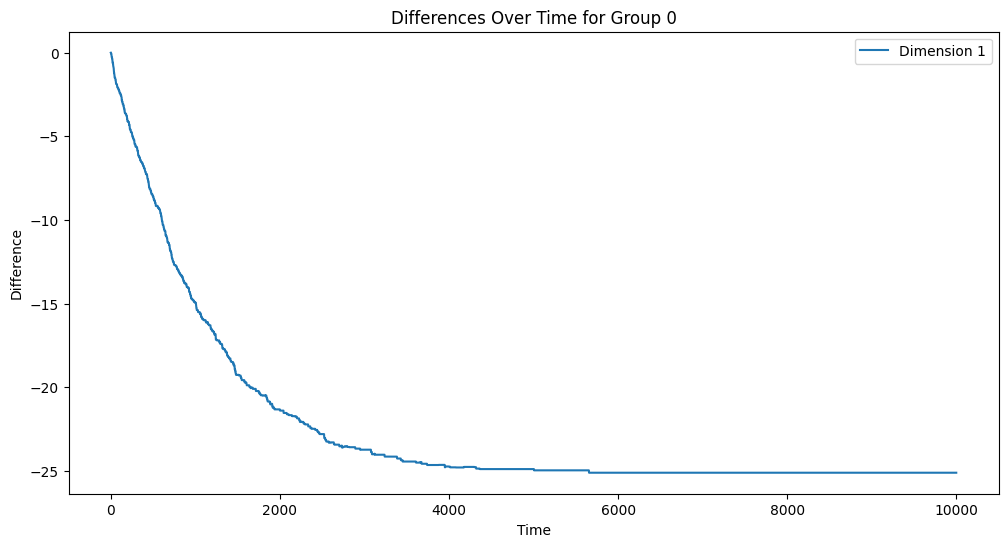

In [ ]:
# Retrieve contents
num_nodes = 1000
num_groups = 2
timesteps = 10000
dims = 1
lowvalence = 0
highvalence = 100

aWidth_to_retrieve = 0
rWidth_to_retrieve = 0
G_retrieved, N_retrieved, N_adj_retrieved = get_simulation_data(num_nodes, num_groups, timesteps, dims, lowvalence, highvalence, aWidth_to_retrieve, rWidth_to_retrieve)

#Calculate difference from group to mean of constituents
group_constituent_differences = calculate_group_constituent_differences(G_retrieved, N_retrieved, N_adj_retrieved)

#Plot group 0
group_to_plot = 0  # For example, to plot the first group
plot_group_differences_over_time(group_constituent_differences, group_to_plot, 1)

## Model 11 - Fast

In [ ]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import h5py

In [ ]:
class GroupshiftSim():

  def __init__(self, G, N, N_adj, lowvalence, highvalence, aWidth, rWidth):
    # This function assumes the following shapes:
    # N = np.random.uniform(0, 100, size=(num_nodes, dims))    #   Node opinion matrix
    # N_adj = np.zeros((num_nodes, timesteps))    #   N_adj matrix
    # G = np.zeros((num_nodes, num_groups, dims, timesteps)) # Group matrix, with each node having a group perception

    self.G = G
    self.N = N
    self.N_adj = N_adj
    self.lowvalence = lowvalence
    self.highvalence = highvalence
    self.aWidth = aWidth
    self.rWidth = rWidth

    #Pull out num_nodes, num_groups, and dims from the arrays
    self.num_nodes, self.dims = N.shape
    _, self.num_groups, _, self.timesteps = G.shape

    # List out who will flip, in order
    self.flip_order = np.random.randint(0,num_nodes,size=(timesteps))

    #Other business
    self.initialize_G()

  # def initialize_G(self):
  #   #INSTANTIATE INITIAL GROUP VALUES
  #   sums = np.zeros((self.num_groups, self.dims)) # Calculate the sum of node values for each group
  #   np.add.at(sums, self.N_adj[:, 0].astype(int), self.N)
  #   counts = np.bincount(self.N_adj[:, 0].astype(int), minlength=self.num_groups) # Calculate the number of nodes in each group
  #   counts[counts == 0] = 1 # Avoid division by zero by replacing zero counts with one # (the corresponding sums are zero, so the division result will still be zero)
  #   self.G[:,:,0] = sums / counts[:, np.newaxis] # Calculate the mean of node values for each group

  def initialize_G(self):
    # INSTANTIATE INITIAL GROUP VALUES
    sums = np.zeros((self.num_groups, self.dims))
    np.add.at(sums, self.N_adj[:, 0].astype(int), self.N)
    counts = np.bincount(self.N_adj[:, 0].astype(int), minlength=self.num_groups)  # Calculate the number of nodes in each group
    counts[counts == 0] = 1  # Avoid division by zero by replacing zero counts with one (the corresponding sums are zero, so the division result will still be zero)

    # Calculate the mean of node values for each group
    mean_values = sums / counts[:, np.newaxis]

    # Duplicate mean_values for each node
    self.G[:, :, :, 0] = np.tile(mean_values, (self.num_nodes, 1, 1)).reshape(self.num_nodes, self.num_groups, self.dims)

#=======================================================
# Simulation functions
#=======================================================

  def runSimulation(self):
    for t in tqdm(range(1,self.timesteps)):
      self.switch_group(t)
      self.repulseAttract(t)

  def switch_group(self, t):
      # Take assignments from the previous timestep for all nodes
      self.N_adj[:, t] = self.N_adj[:, t-1]

      # Node to be updated
      node_idx = self.flip_order[t]
      node_values = self.N[node_idx]

      # Compute distances of this node to all group centroids from the previous timestep
      distances = np.linalg.norm(node_values - self.G[node_idx, :, :, t-1], axis=1)

      # Find the closest group
      closest_group = np.argmin(distances)

      # Update group assignment for this node
      self.N_adj[node_idx, t] = closest_group

  def attract(self, t):
      # Node to be updated
      node_idx = self.flip_order[t]
      effects = np.zeros_like(self.G[node_idx, :, :, t]) # .shape = (num_groups, dims)

      # For each group
      for i in range(self.num_groups):
          # Get member valences/opinions for the current timestep
          members_idx = np.where(self.N_adj[:, t] == i)[0]
          membervalences = self.N[members_idx]

          if len(members_idx) == 0:
            continue

          # Compute the distances & update based on the previous group's opinion
          op = self.G[node_idx, i, :, t-1]
          pointing = np.sign(membervalences - op)
          distance = np.abs(membervalences - op)
          delta_op = pointing * np.exp(-1 * (1/self.aWidth) * distance) * (1/len(members_idx))

          # Sum the changes and apply bounds
          effects[i] = delta_op.sum(axis=0) #Sums over dims

      return effects

  def repulse(self, t):
      # Node to be updated
      node_idx = self.flip_order[t]
      effects = np.zeros_like(self.G[node_idx, :, :, t])
      # For each group
      for i in range(self.G[node_idx].shape[0]):
          # Calculate repulsion from all other groups based on the previous group's opinion
          op = self.G[node_idx, i, :, t-1]
          aggregated_delta = np.zeros(op.shape)

          for j in range(self.G[node_idx].shape[0]):
              if i != j:  # We don't want self-repulsion
                  pointing = -np.sign(self.G[node_idx, j, :, t-1] - op)
                  distance = np.abs(self.G[node_idx, j, :, t-1] - op)
                  delta_op = pointing * np.exp(-1 * (1/self.rWidth) * distance)

                  # Accumulate the changes for the current group

                  aggregated_delta += delta_op

          # Update the group opinion using the accumulated repulsion effects and enforce bounds
          effects[i] = aggregated_delta

      return effects

  def repulseAttract(self, t, use_attraction=True, use_repulsion=True):
      #Carry over everyone's perceptions to the next time step
      self.G[:,:,:,t] = self.G[:,:,:,t-1]

      # Node to be updated
      node_idx = self.flip_order[t]
      total_effects = np.zeros_like(self.G[node_idx, :, :, t])

      if use_attraction:
          attraction_effects = self.attract(t)
          total_effects += attraction_effects

      if use_repulsion:
          repulsion_effects = self.repulse(t)
          total_effects += repulsion_effects

      new_opinions = self.G[node_idx, :, :, t-1] + total_effects
      self.G[node_idx, :, :, t] = np.clip(new_opinions, self.lowvalence, self.highvalence)


#=======================================================
# Plotting functions
#=======================================================

  def plot_group_values(self):
      # Create a figure and axis
      fig, ax = plt.subplots(self.dims, figsize=(10, 5 * self.dims))

      # If there's only one dimension, make ax an array for consistency
      if self.dims == 1:
          ax = [ax]

      # For each dimension
      for d in range(self.dims):
          # Plot the group value for each group in the current dimension over time
          for group in range(self.G.shape[0]):
              ax[d].plot(self.G[group, d, :], label=f'Group {group}')

              # Calculate and plot the mean opinion of the constituents for the current group over time
              mean_opinions = []
              for t in range(self.G.shape[2]):
                  group_members = self.N[self.N_adj[:, t] == group]
                  mean_opinion = np.mean(group_members[:, d])
                  mean_opinions.append(mean_opinion)
              ax[d].plot(mean_opinions, 'r-.', label=f'Mean Opinion Group {group}')

          ax[d].set_title(f'Dimension {d + 1}')
          ax[d].set_xlabel('Time')
          ax[d].set_ylabel('Value')
          ax[d].legend()
          ax[d].set_ylim((self.lowvalence,self.highvalence))

      plt.tight_layout()
      plt.show()

  def plot_group_values2(self):
      # Create a figure and axis
      fig, ax = plt.subplots(self.dims, figsize=(10, 5 * self.dims))

      # If there's only one dimension, make ax an array for consistency
      if self.dims == 1:
          ax = [ax]

      # For each dimension and each group
      for d in range(self.dims):
          for group in range(self.num_groups):
              #Calculate mean opinions of constituents
              mean_opinions = []
              for t in range(self.timesteps):
                  group_members = self.N[self.N_adj[:, t] == group]
                  mean_opinion = np.mean(group_members[:, d])
                  mean_opinions.append(mean_opinion)
              ax[d].plot(mean_opinions, 'r-.', label=f'Mean Opinion Group {group}')

              for perception_group in range(self.num_groups):
                  # Calculate and plot the mean perception of the constituents for the current group over time
                  mean_perceptions = []
                  for t in range(self.timesteps):
                      # Get the members of the group
                      group_members = np.where(self.N_adj[:, t] == group)[0]
                      if len(group_members) > 0:
                          mean_perception = np.mean(self.G[group_members, perception_group, d, t])
                      else:
                          mean_perception = np.nan
                      mean_perceptions.append(mean_perception)

                  # Set line style based on whether the group is perceiving itself or another group
                  if group == perception_group:
                      linestyle = '-'
                  else:
                      linestyle = '--'

                  ax[d].plot(mean_perceptions, label=f'Group {group} perception of Group {perception_group}', linestyle=linestyle, alpha=0.6)

          ax[d].set_title(f'Dimension {d + 1}')
          ax[d].set_xlabel('Time')
          ax[d].set_ylabel('Value')
          ax[d].legend()
          ax[d].set_ylim((self.lowvalence, self.highvalence))

      plt.tight_layout()
      plt.show()


In [ ]:
num_nodes = 1000
num_groups = 2
timesteps = 100000
dims = 1
lowvalence = 0
highvalence = 100
aWidth = 5
rWidth = 7

#   Node opinion matrix
N = np.random.uniform(0, 100, size=(num_nodes, dims))

#   N_adj matrix
N_adj = np.zeros((num_nodes, timesteps))
N_adj[:,0] = np.random.randint(0,num_groups,size=(num_nodes))

G = np.zeros((num_nodes, num_groups, dims, timesteps))

#=======================================================
# Initial state
#=======================================================

testSim = GroupshiftSim(G, N, N_adj, lowvalence, highvalence, aWidth, rWidth)
testSim.runSimulation()

100%|██████████| 99999/99999 [00:47<00:00, 2103.74it/s]


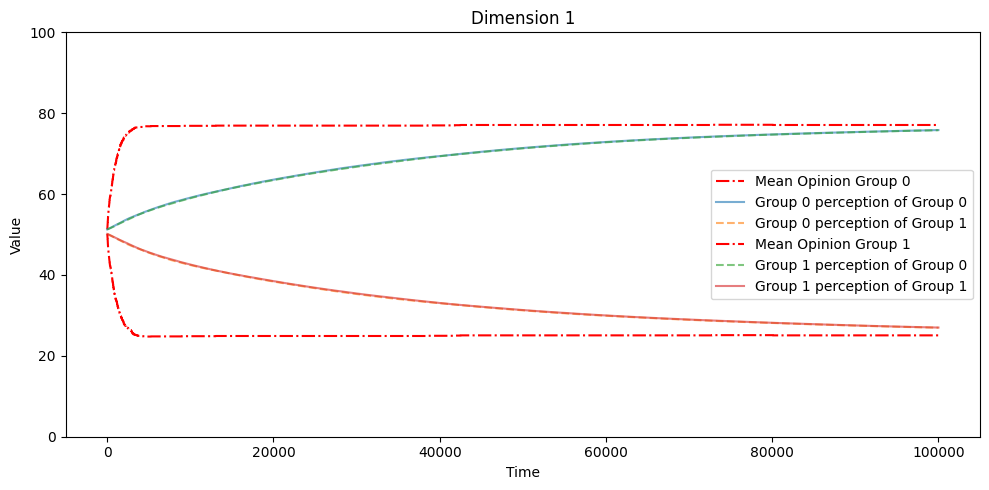

In [ ]:
testSim.plot_group_values2()

In [ ]:
testSim.G

array([[[[50.22486649, 50.22486649, 50.22486649, ..., 64.16082865,
          64.16082865, 64.16082865]],

        [[49.0350275 , 49.0350275 , 49.0350275 , ..., 35.33213345,
          35.33213345, 35.33213345]]],


       [[[50.22486649, 50.22486649, 50.22486649, ..., 61.77613814,
          61.77613814, 61.77613814]],

        [[49.0350275 , 49.0350275 , 49.0350275 , ..., 37.7890753 ,
          37.7890753 , 37.7890753 ]]],


       [[[50.22486649, 50.22486649, 50.22486649, ..., 62.66997633,
          62.66997633, 62.66997633]],

        [[49.0350275 , 49.0350275 , 49.0350275 , ..., 36.90817986,
          36.90817986, 36.90817986]]],


       ...,


       [[[50.22486649, 50.22486649, 50.22486649, ..., 62.78696809,
          62.78696809, 62.78696809]],

        [[49.0350275 , 49.0350275 , 49.0350275 , ..., 36.72300197,
          36.72300197, 36.72300197]]],


       [[[50.22486649, 50.22486649, 50.22486649, ..., 59.85772586,
          59.85772586, 59.85772586]],

        [[49.0350275 , 4

## Model 11 - mods

Allow more than one spin to flip per time step (introduce temperature)

In [ ]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
class GroupshiftSim():

  def __init__(self, G, N, N_adj, temp, lowvalence, highvalence, aWidth, rWidth):
    # This function assumes the following shapes:
    # N = np.random.uniform(0, 100, size=(num_nodes, dims))    #   Node opinion matrix
    # N_adj = np.zeros((num_nodes, timesteps))    #   N_adj matrix
    # G = np.zeros((num_nodes, num_groups, dims, timesteps)) # Group matrix, with each node having a group perception

    self.G = G
    self.N = N
    self.N_adj = N_adj
    self.lowvalence = lowvalence
    self.highvalence = highvalence
    self.aWidth = aWidth
    self.rWidth = rWidth
    self.temp = temp #Number of nodes to flip per timestep

    #Pull out num_nodes, num_groups, and dims from the arrays
    self.num_nodes, self.dims = N.shape
    _, self.num_groups, _, self.timesteps = G.shape

    # List out who will flip, in order
    self.flip_order = np.random.randint(0,num_nodes,size=(timesteps))

    #Other business
    self.initialize_G()

  def initialize_G(self):
    # INSTANTIATE INITIAL GROUP VALUES
    sums = np.zeros((self.num_groups, self.dims))
    np.add.at(sums, self.N_adj[:, 0].astype(int), self.N)
    counts = np.bincount(self.N_adj[:, 0].astype(int), minlength=self.num_groups)  # Calculate the number of nodes in each group
    counts[counts == 0] = 1  # Avoid division by zero by replacing zero counts with one (the corresponding sums are zero, so the division result will still be zero)

    # Calculate the mean of node values for each group
    mean_values = sums / counts[:, np.newaxis]

    # Duplicate mean_values for each node
    self.G[:, :, :, 0] = np.tile(mean_values, (self.num_nodes, 1, 1)).reshape(self.num_nodes, self.num_groups, self.dims)

#=======================================================
# Simulation functions
#=======================================================

  def runSimulation(self):
    for t in tqdm(range(1,self.timesteps)):
      affected_nodes = np.random.choice(range(self.num_nodes), self.temp, replace=False)
      self.carryOver(t)
      self.switch_group(t, affected_nodes)
      self.repulseAttract(t, affected_nodes)

  def carryOver(self, t):
      # Take assignments from the previous timestep for all nodes
      self.N_adj[:, t] = self.N_adj[:, t-1]

      #Carry over everyone's perceptions to the next time step
      self.G[:,:,:,t] = self.G[:,:,:,t-1]

  def switch_group(self, t, affected_nodes):
      for node_idx in affected_nodes:
      # Node to be updated
        node_values = self.N[node_idx]

        # Compute distances of this node to all group centroids from the previous timestep
        distances = np.linalg.norm(node_values - self.G[node_idx, :, :, t-1], axis=1)

        # Find the closest group
        closest_group = np.argmin(distances)

        # Update group assignment for this node
        self.N_adj[node_idx, t] = closest_group

  def attract(self, t, node_idx):
      # Node to be updated
      effects = np.zeros_like(self.G[node_idx, :, :, t]) # .shape = (num_groups, dims)

      # For the group that node is in
      g = int(self.N_adj[node_idx, t])

      # Get member valences/opinions for the current timestep
      members_idx = np.where(self.N_adj[:, t] == g)[0]
      membervalences = self.N[members_idx]

      if len(members_idx) == 0:
        return effects

      # Compute the distances & update based on the previous group's opinion
      op = self.G[node_idx, g, :, t-1]
      pointing = np.sign(membervalences - op)
      distance = np.abs(membervalences - op)
      delta_op = pointing * np.exp(-1 * (1/self.aWidth) * distance)# * (1/len(members_idx))

      # Sum the changes and apply bounds
      effects[g] = delta_op.sum(axis=0) #Sums over dims

      return effects

  def repulse(self, t, node_idx):
      # Node to be updated
      #node_idx = self.flip_order[t]
      effects = np.zeros_like(self.G[node_idx, :, :, t])
      # For each group
      for i in range(self.G[node_idx].shape[0]):
          # Calculate repulsion from all other groups based on the previous group's opinion
          op = self.G[node_idx, i, :, t-1]
          aggregated_delta = np.zeros(op.shape)

          for j in range(self.G[node_idx].shape[0]):
              if i != j:  # We don't want self-repulsion
                  pointing = -np.sign(self.G[node_idx, j, :, t-1] - op)
                  distance = np.abs(self.G[node_idx, j, :, t-1] - op)
                  delta_op = pointing * np.exp(-1 * (1/self.rWidth) * distance)

                  # Accumulate the changes for the current group

                  aggregated_delta += delta_op

          # Update the group opinion using the accumulated repulsion effects and enforce bounds
          effects[i] = aggregated_delta

      return effects

  def repulseAttract(self, t, affected_nodes, use_attraction=True, use_repulsion=True):
      for node_idx in affected_nodes:
        # Node to be updated
        #node_idx = self.flip_order[t]
        total_effects = np.zeros_like(self.G[node_idx, :, :, t])

        if use_attraction:
            attraction_effects = self.attract(t, node_idx)
            total_effects += attraction_effects

        if use_repulsion:
            repulsion_effects = self.repulse(t, node_idx)
            total_effects += repulsion_effects

        new_opinions = self.G[node_idx, :, :, t-1] + total_effects
        self.G[node_idx, :, :, t] = np.clip(new_opinions, self.lowvalence, self.highvalence)


#=======================================================
# Plotting functions
#=======================================================

  def plot_group_values2(self):
      # Create a figure and axis
      fig, ax = plt.subplots(self.dims, figsize=(10, 5 * self.dims))

      # If there's only one dimension, make ax an array for consistency
      if self.dims == 1:
          ax = [ax]

      # For each dimension and each group
      for d in range(self.dims):
          #perceptionlines = {}
          for group in range(self.num_groups):
              #Calculate mean opinions of constituents
              mean_opinions = []
              for t in range(self.timesteps):
                  group_members = self.N[self.N_adj[:, t] == group]
                  mean_opinion = np.mean(group_members[:, d])
                  mean_opinions.append(mean_opinion)
              ax[d].plot(mean_opinions, 'r-.', label=f'Mean Opinion Group {group}')

              # Calculate and plot the mean perception of the constituents for the current group over time
              for perception_group in range(self.num_groups):

                  mean_perceptions = []
                  for t in range(self.timesteps):
                      # Get the members of the group
                      group_members = np.where(self.N_adj[:, t] == group)[0]
                      if len(group_members) > 0:
                          mean_perception = np.mean(self.G[group_members, perception_group, d, t])
                      else:
                          mean_perception = np.nan
                      mean_perceptions.append(mean_perception)

                  # Set line style based on whether the group is perceiving itself or another group
                  if group == perception_group:
                      linestyle = '-'
                  else:
                      linestyle = '--'

                  ax[d].plot(mean_perceptions, label=f'Group {group} perception of Group {perception_group}', linestyle=linestyle, alpha=0.6)
                  #perceptionlines[f'Group {group} perception of Group {perception_group}'] = mean_perceptions

                  # if perception_group == group:
                  #   diffs = np.array(mean_perceptions) - np.array(mean_opinions)
                  #   print( np.mean( diffs[self.timesteps - 500:] ) )

          ax[d].set_title(f'Dimension {d + 1}')
          ax[d].set_xlabel('Time')
          ax[d].set_ylabel('Value')
          ax[d].legend()
          ax[d].set_ylim((self.lowvalence, self.highvalence))

      plt.tight_layout()
      plt.show()

      #return perceptionlines


In [ ]:
num_nodes = 1000
num_groups = 2
timesteps = 10000
dims = 1
temp = 20
lowvalence = 0
highvalence = 100
aWidth = 7 # 0 to 10
rWidth = 14 # Less than 50?

#   Node opinion matrix
N = np.random.uniform(0, 100, size=(num_nodes, dims))

#   N_adj matrix
N_adj = np.zeros((num_nodes, timesteps))
N_adj[:,0] = np.random.randint(0,num_groups,size=(num_nodes))

G = np.zeros((num_nodes, num_groups, dims, timesteps))

#=======================================================
# Initial state
#=======================================================

testSim = GroupshiftSim(G, N, N_adj, temp, lowvalence, highvalence, aWidth, rWidth)
testSim.runSimulation()

100%|██████████| 9999/9999 [00:35<00:00, 283.10it/s]


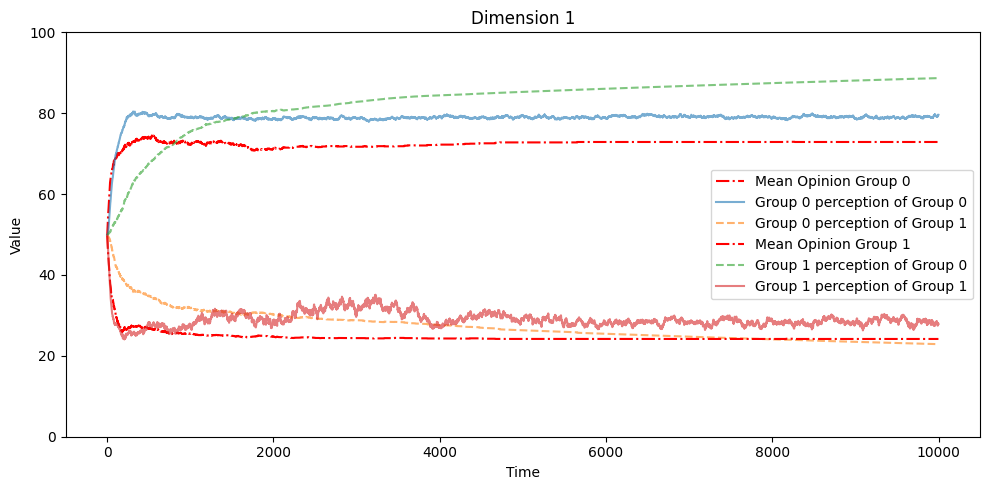

In [ ]:
plines = testSim.plot_group_values2()

Results for 0


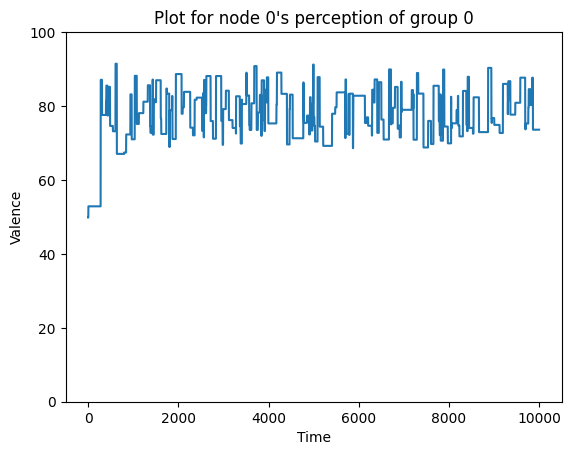

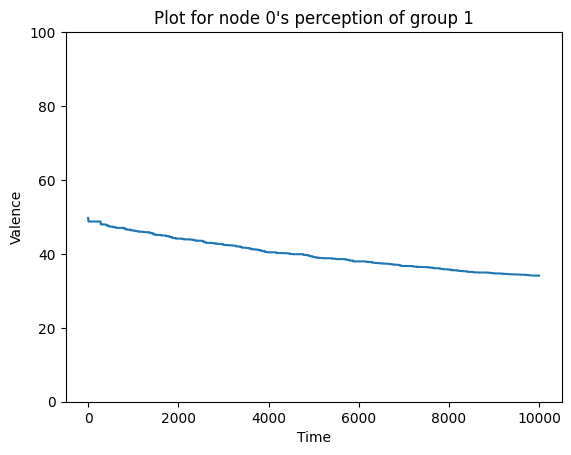

In [ ]:
dims = 0
for node_idx in range(1):
  print(f"Results for {node_idx}")
  for group_perception in range(testSim.num_groups):
    plt.plot( testSim.G[node_idx, group_perception, dims, :] )
    plt.title(f"Plot for node {node_idx}'s perception of group {group_perception}")  # Set the title of the plot
    plt.ylim((0,100))
    plt.xlabel("Time")
    plt.ylabel("Valence")
    plt.show()

### Monte Carlo

This is code for running many simulations, extracting a metric, and plotting the result.


In [ ]:
import h5py
from scipy.stats import truncnorm

def plotSim(filename, simnum):
    # Extract parameters
    num_nodes, num_groups, timesteps, dims, temp, disttype = paramsFromFilename(filename)
    lowvalence = 0
    highvalence = 100
    aWidth = 5
    rWidth = 20

    G, N, N_adj = get_simulation_data(num_nodes, num_groups, timesteps, dims, temp, lowvalence, highvalence, aWidth, rWidth, simnum, disttype)

    # Create a figure and axis
    fig, ax = plt.subplots(dims, figsize=(10, 5 * dims))

    # If there's only one dimension, make ax an array for consistency
    if dims == 1:
        ax = [ax]

    # For each dimension and each group
    for d in range(dims):
        #perceptionlines = {}
        for group in range(num_groups):
            #Calculate mean opinions of constituents
            mean_opinions = []
            for t in range(timesteps):
                group_members = N[N_adj[:, t] == group]
                mean_opinion = np.mean(group_members[:, d])
                mean_opinions.append(mean_opinion)
            ax[d].plot(mean_opinions, 'r-.', label=f'Mean Opinion Group {group}')

            # Calculate and plot the mean perception of the constituents for the current group over time
            for perception_group in range(num_groups):

                mean_perceptions = []
                for t in range(timesteps):
                    # Get the members of the group
                    group_members = np.where(N_adj[:, t] == group)[0]
                    if len(group_members) > 0:
                        mean_perception = np.mean(G[group_members, perception_group, d, t])
                    else:
                        mean_perception = np.nan
                    mean_perceptions.append(mean_perception)

                # Set line style based on whether the group is perceiving itself or another group
                if group == perception_group:
                    linestyle = '-'
                else:
                    linestyle = '--'

                ax[d].plot(mean_perceptions, label=f'Group {group} perception of Group {perception_group}', linestyle=linestyle, alpha=0.6)
                #perceptionlines[f'Group {group} perception of Group {perception_group}'] = mean_perceptions

        ax[d].set_title(f'Dimension {d + 1}')
        ax[d].set_xlabel('Time')
        ax[d].set_ylabel('Value')
        ax[d].legend()
        ax[d].set_ylim((lowvalence, highvalence))

    plt.tight_layout()
    plt.show()

    #return perceptionlines

def filenameFromParams(num_nodes, num_groups, timesteps, dims, temp, lowvalence, highvalence, aWidth, rWidth, num_sims, disttype = "uniform"):
    params_for_filename = '.'.join([str(x) for x in ['N',num_nodes, 'G',num_groups, 'T', timesteps, 'D', dims, "temp", temp, "dist", disttype]])
    return 'simulation_results_'+params_for_filename+'.hdf5'

def paramsFromFilename(filename):
    # Remove the prefix and suffix from the filename
    core_filename = filename[len('simulation_results_'):-len('.hdf5')]

    # Split the core filename into components
    params_list = core_filename.split('.')

    # Extract parameters based on their positions
    num_nodes = int(params_list[1])
    num_groups = int(params_list[3])
    timesteps = int(params_list[5])
    dims = int(params_list[7])
    temp = int(params_list[9])
    disttype = params_list[11]

    return num_nodes, num_groups, timesteps, dims, temp, disttype


def runSimAndStore(num_nodes, num_groups, timesteps, dims, temp, lowvalence, highvalence, aWidth, rWidth, num_sims, disttype = "uniform"):
    filename = filenameFromParams(num_nodes, num_groups, timesteps, dims, temp, lowvalence, highvalence, aWidth, rWidth, num_sims, disttype = "uniform")
    # Define the HDF5 file to store results
    with h5py.File(filename, 'w') as f:
        for simnum in range(num_sims):
            if disttype == "uniform":
                #   Node opinion matrix
                N = np.random.uniform(0, 100, size=(num_nodes, dims))
            elif disttype == "gaussian":
                # Initialize Gaussian, with truncated normal dist
                # Parameters for the truncated normal distribution
                mean, std_dev = 50, 25

                # Calculate the parameters for truncnorm
                lower, upper = (lowvalence - mean) / std_dev, (highvalence - mean) / std_dev

                # Generate the truncated normal distribution
                N = truncnorm.rvs(lower, upper, loc=mean, scale=std_dev, size=(num_nodes, dims))
            elif type(disttype) == type([]):
                raise Exception("Not implemented yet.")
            else:
                raise ValueError("Invalid type of distribution for simulation.")

            #   N_adj matrix
            N_adj = np.zeros((num_nodes, timesteps))
            N_adj[:,0] = np.random.randint(0,num_groups,size=(num_nodes))

            G = np.zeros((num_nodes, num_groups, dims, timesteps))

            # Run simulation
            sim = GroupshiftSim(G, N, N_adj, temp, lowvalence, highvalence, aWidth, rWidth)
            sim.runSimulation()

            # Store results in HDF5
            grp_name = f"simulation_{simnum}"
            grp = f.create_group(grp_name)
            grp.create_dataset('G', data=sim.G)
            grp.create_dataset('N', data=sim.N)
            grp.create_dataset('N_adj', data=sim.N_adj)

def get_simulation_data(num_nodes, num_groups, timesteps, dims, temp, lowvalence, highvalence, aWidth, rWidth, simnum, disttype = "uniform"):
    filename = filenameFromParams(num_nodes, num_groups, timesteps, dims, temp, lowvalence, highvalence, aWidth, rWidth, num_sims, disttype = "uniform")
    # Open the HDF5 file in read mode
    with h5py.File(filename, 'r') as hdf5_file:
        # Construct the group name based on the given parameters
        group_name = f'simulation_{simnum}'

        # Check if the group exists in the file
        if group_name in hdf5_file:
            # Extract datasets
            G_data = hdf5_file[group_name]['G'][:]
            N_data = hdf5_file[group_name]['N'][:]
            N_adj_data = hdf5_file[group_name]['N_adj'][:]
            return G_data, N_data, N_adj_data
        else:
            raise ValueError(f"No simulations found for {group_name}")

def calcPlurg2Scatter(G, N, N_adj, num_timesteps_to_average = 500):
  # Get the number of timesteps
  total_timesteps = G.shape[-1]
  start_timestep = total_timesteps - num_timesteps_to_average

  dim = 0
  result = []
  for group in range(num_groups):
    groupmean = []
    for t in range(start_timestep,total_timesteps):
      group_members = np.where(N_adj[:, t] == group)
      diff = G[group_members, group, dim, t] - N[group_members].T
      groupmean.append(np.mean(diff))
    groupmean = np.mean(groupmean)
    result.append(groupmean)
  return result


def scatterPlurg(filenames):
  if type(filenames) != type([]) and type(filenames) == type(""):
    filenames = [filenames]
  elif type(filenames) != type([]) and type(filenames) != type(""):
    raise ValueError("Error with 'filenames': incorrect type.")

  result = []
  for filename in filenames:
    with h5py.File(filename, 'r') as hdf5_file:
      for grp_name in hdf5_file.keys():
        grp = hdf5_file[grp_name]
        G = grp['G'][:]
        N = grp['N'][:]
        N_adj = grp['N_adj'][:]
        datapoint = calcPlurg2Scatter(G, N, N_adj)
        result.append( datapoint )

  #Create a scatter plot using result
  df = pd.DataFrame(result, columns=['x', 'y'])
  sns.scatterplot(data=df, x='x', y='y')
  plt.show()

  return result

In [ ]:
#=======================================================
# MAIN
#=======================================================

num_sims = 1
num_nodes = 1000
num_groups = 2
timesteps = 10000
dims = 1
temp = 20
lowvalence = 0
highvalence = 100
aWidth = 5
rWidth = 20

In [ ]:
# For each of the dictionaries of parameters, execute the run_simulation_and_store function
runSimAndStore(num_nodes, num_groups, timesteps, dims, temp, lowvalence, highvalence, aWidth, rWidth, num_sims)

100%|██████████| 9999/9999 [00:57<00:00, 174.10it/s]


In [ ]:
#Getting a single simulation
simnum = 0
G, N, N_adj = get_simulation_data(num_nodes, num_groups, timesteps, dims, temp, lowvalence, highvalence, aWidth, rWidth, simnum, disttype = "uniform")
calcPlurg2Scatter(G, N, N_adj)

[3.4491574029716374, 0.7071058541904444]

In [ ]:
plotSim('simulation_results_N.1000.G.2.T.10000.D.1.temp.20.dist.uniform.hdf5', 1)

ValueError: No simulations found for simulation_1

Code for calculating the mean difference between perception groups for the last 500 timesteps (WIP)

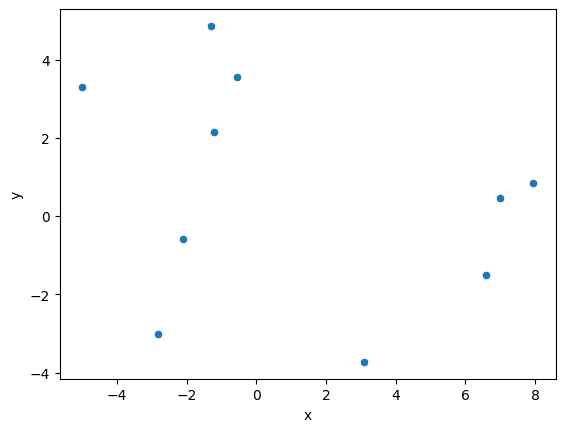

In [ ]:
output = scatterPlurg(['simulation_results_N.1000.G.2.T.10000.D.1.temp.20.dist.uniform.hdf5'])

## Model 13 - Sampling





In [ ]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
class GroupshiftSim():

  def __init__(self, G, N, N_adj, temp, lowvalence, highvalence, aWidth, rWidth, attractSS, repulseSS):
    # This function assumes the following shapes:
    # N = np.random.uniform(0, 100, size=(num_nodes, dims))    #   Node opinion matrix
    # N_adj = np.zeros((num_nodes, timesteps))    #   N_adj matrix
    # G = np.zeros((num_nodes, num_groups, dims, timesteps)) # Group matrix, with each node having a group perception

    self.G = G
    self.N = N
    self.N_adj = N_adj
    self.lowvalence = lowvalence
    self.highvalence = highvalence
    self.aWidth = aWidth
    self.rWidth = rWidth
    self.temp = temp #Number of nodes to flip per timestep
    self.attractSS = attractSS
    self.repulseSS = repulseSS

    #Pull out num_nodes, num_groups, and dims from the arrays
    self.num_nodes, self.dims = N.shape
    _, self.num_groups, _, self.timesteps = G.shape

    # List out who will flip, in order
    self.flip_order = np.random.randint(0,num_nodes,size=(timesteps))

    #Other business
    self.initialize_G()

  def initialize_G(self):
    # INSTANTIATE INITIAL GROUP VALUES
    sums = np.zeros((self.num_groups, self.dims))
    np.add.at(sums, self.N_adj[:, 0].astype(int), self.N)
    counts = np.bincount(self.N_adj[:, 0].astype(int), minlength=self.num_groups)  # Calculate the number of nodes in each group
    counts[counts == 0] = 1  # Avoid division by zero by replacing zero counts with one (the corresponding sums are zero, so the division result will still be zero)

    # Calculate the mean of node values for each group
    mean_values = sums / counts[:, np.newaxis]

    # Duplicate mean_values for each node
    self.G[:, :, :, 0] = np.tile(mean_values, (self.num_nodes, 1, 1)).reshape(self.num_nodes, self.num_groups, self.dims)

#=======================================================
# Simulation functions
#=======================================================

  def runSimulation(self):
    for t in tqdm(range(1,self.timesteps)):
      affected_nodes = np.random.choice(range(self.num_nodes), self.temp, replace=False)
      self.carryOver(t)
      self.switch_group(t, affected_nodes)
      # self.repulseAttract(t, affected_nodes)
      self.sampleSample(t, affected_nodes)

  def carryOver(self, t):
      # Take assignments from the previous timestep for all nodes
      self.N_adj[:, t] = self.N_adj[:, t-1]

      #Carry over everyone's perceptions to the next time step
      self.G[:,:,:,t] = self.G[:,:,:,t-1]

  def switch_group(self, t, affected_nodes):
      for node_idx in affected_nodes:
      # Node to be updated
        node_values = self.N[node_idx]

        # Compute distances of this node to all group centroids from the previous timestep
        distances = np.linalg.norm(node_values - self.G[node_idx, :, :, t-1], axis=1)

        # Find the closest group
        closest_group = np.argmin(distances)

        # Update group assignment for this node
        self.N_adj[node_idx, t] = closest_group

  def attract(self, t, node_idx):
      # Node to be updated
      effects = np.zeros_like(self.G[node_idx, :, :, t]) # .shape = (num_groups, dims)

      # For the group that node is in
      g = int(self.N_adj[node_idx, t])

      # Get member valences/opinions for the current timestep
      members_idx = np.where(self.N_adj[:, t] == g)[0]
      membervalences = self.N[members_idx]

      if len(members_idx) == 0:
        return effects

      # Compute the distances & update based on the previous group's opinion
      op = self.G[node_idx, g, :, t-1]
      pointing = np.sign(membervalences - op)
      distance = np.abs(membervalences - op)
      delta_op = pointing * np.exp(-1 * (1/self.aWidth) * distance)# * (1/len(members_idx))

      # Sum the changes and apply bounds
      effects[g] = delta_op.sum(axis=0) #Sums over dims

      return effects

  def repulse(self, t, node_idx):
      # Node to be updated
      #node_idx = self.flip_order[t]
      effects = np.zeros_like(self.G[node_idx, :, :, t])
      # For each group
      for i in range(self.G[node_idx].shape[0]):
          # Calculate repulsion from all other groups based on the previous group's opinion
          op = self.G[node_idx, i, :, t-1]
          aggregated_delta = np.zeros(op.shape)

          for j in range(self.G[node_idx].shape[0]):
              if i != j:  # We don't want self-repulsion
                  pointing = -np.sign(self.G[node_idx, j, :, t-1] - op)
                  distance = np.abs(self.G[node_idx, j, :, t-1] - op)
                  delta_op = pointing * np.exp(-1 * (1/self.rWidth) * distance)

                  # Accumulate the changes for the current group

                  aggregated_delta += delta_op

          # Update the group opinion using the accumulated repulsion effects and enforce bounds
          effects[i] = aggregated_delta

      return effects

  def repulseAttract(self, t, affected_nodes, use_attraction=True, use_repulsion=True):
      for node_idx in affected_nodes:
        # Node to be updated
        #node_idx = self.flip_order[t]
        total_effects = np.zeros_like(self.G[node_idx, :, :, t])

        if use_attraction:
            attraction_effects = self.attract(t, node_idx)
            total_effects += attraction_effects

        if use_repulsion:
            repulsion_effects = self.repulse(t, node_idx)
            total_effects += repulsion_effects

        new_opinions = self.G[node_idx, :, :, t-1] + total_effects
        self.G[node_idx, :, :, t] = np.clip(new_opinions, self.lowvalence, self.highvalence)


  def attractSample(self, t, node_idx):
      # Node to be updated
      effects = np.zeros_like(self.G[node_idx, :, :, t]) # .shape = (num_groups, dims)

      # For the group that node is in
      g = int(self.N_adj[node_idx, t])

      # Get member valences/opinions for the current timestep
      members_idx = np.where(self.N_adj[:, t] == g)[0]
      membervalences = self.N[members_idx]

      if len(members_idx) == 0:
        return effects

      # This selects X random indices from the total number of nodes (without replacement)
      random_indices = np.random.choice(self.num_nodes, self.attractSS, replace=False)

      # Step 2: Take the mean of the selected vectors along axis 0 (rows)
      mean_opinion_vector = np.mean(self.N[random_indices], axis=0)

      # # Compute the distances & update based on the previous group's opinion
      # op = self.G[node_idx, g, :, t-1]
      # pointing = np.sign(membervalences - op)
      # distance = np.abs(membervalences - op)
      # delta_op = pointing * np.exp(-1 * (1/self.aWidth) * distance)# * (1/len(members_idx))

      # # Sum the changes and apply bounds
      # effects[g] = delta_op.sum(axis=0) #Sums over dims

      return mean_opinion_vector

  def repulseSample(self, t, node_idx): #This function runs sampling for all cases
      effects = np.zeros_like(self.G[node_idx, :, :, t]) # (G , dims) matrix
      g = int(self.N_adj[node_idx, t])
      # For each group
      for i in range(self.num_groups):
          if i==g:
              sample_size = self.attractSS
          else:
              sample_size = self.repulseSS

          members_idx = np.where(self.N_adj[:, t] == i)[0] # Get members of that group
          membervalences = self.N[members_idx]

          if len(members_idx) == 0:
              effects[i] = self.G[node_idx, i, :, t-1] # Maintain previous perception
          elif len(members_idx) < sample_size < 0:
              raise ValueError("Sample size is too large for the number of members in the group.")
          else:
              random_indices = np.random.choice(membervalences.shape[0], sample_size, replace=False)
              effects[i] = np.mean(membervalences[random_indices], axis=0) #Sum over dimensions of the sample

      # Update that node's perceptions
      self.G[node_idx, :, :, t] = np.clip(effects, self.lowvalence, self.highvalence)

      return effects

  def sampleSample(self, t, affected_nodes):
      for node_idx in affected_nodes:
          self.repulseSample(t,node_idx)


#=======================================================
# Plotting functions
#=======================================================

  def plot_group_values2(self):
      # Create a figure and axis
      fig, ax = plt.subplots(self.dims, figsize=(10, 5 * self.dims))

      # If there's only one dimension, make ax an array for consistency
      if self.dims == 1:
          ax = [ax]

      # For each dimension and each group
      for d in range(self.dims):
          #perceptionlines = {}
          for group in range(self.num_groups):
              #Calculate mean opinions of constituents
              mean_opinions = []
              for t in range(self.timesteps):
                  group_members = self.N[self.N_adj[:, t] == group]
                  mean_opinion = np.mean(group_members[:, d])
                  mean_opinions.append(mean_opinion)
              ax[d].plot(mean_opinions, 'r-.', label=f'Mean Opinion Group {group}')

              # Calculate and plot the mean perception of the constituents for the current group over time
              for perception_group in range(self.num_groups):

                  mean_perceptions = []
                  for t in range(self.timesteps):
                      # Get the members of the group
                      group_members = np.where(self.N_adj[:, t] == group)[0]
                      if len(group_members) > 0:
                          mean_perception = np.mean(self.G[group_members, perception_group, d, t])
                      else:
                          mean_perception = np.nan
                      mean_perceptions.append(mean_perception)

                  # Set line style based on whether the group is perceiving itself or another group
                  if group == perception_group:
                      linestyle = '-'
                  else:
                      linestyle = '--'

                  ax[d].plot(mean_perceptions, label=f'Group {group} perception of Group {perception_group}', linestyle=linestyle, alpha=0.6)
                  #perceptionlines[f'Group {group} perception of Group {perception_group}'] = mean_perceptions

                  # if perception_group == group:
                  #   diffs = np.array(mean_perceptions) - np.array(mean_opinions)
                  #   print( np.mean( diffs[self.timesteps - 500:] ) )

          ax[d].set_title(f'Dimension {d + 1}')
          ax[d].set_xlabel('Time')
          ax[d].set_ylabel('Value')
          ax[d].legend()
          ax[d].set_ylim((self.lowvalence, self.highvalence))

      plt.tight_layout()
      plt.show()

      #return perceptionlines


In [ ]:
num_nodes = 1000
num_groups = 2
timesteps = 2000
dims = 1
temp = 20
lowvalence = 0
highvalence = 100
aWidth = 7 # 0 to 10
rWidth = 20 # Less than 50?
attractSS = 100
repulseSS = 10

#   Node opinion matrix
N = np.random.uniform(0, 100, size=(num_nodes, dims))

#   N_adj matrix
N_adj = np.zeros((num_nodes, timesteps))
N_adj[:,0] = np.random.randint(0,num_groups,size=(num_nodes))

G = np.zeros((num_nodes, num_groups, dims, timesteps))

#=======================================================
# Initial state
#=======================================================

testSim = GroupshiftSim(G, N, N_adj, temp, lowvalence, highvalence, aWidth, rWidth, attractSS, repulseSS)
testSim.runSimulation()

100%|██████████| 1999/1999 [00:13<00:00, 150.49it/s]


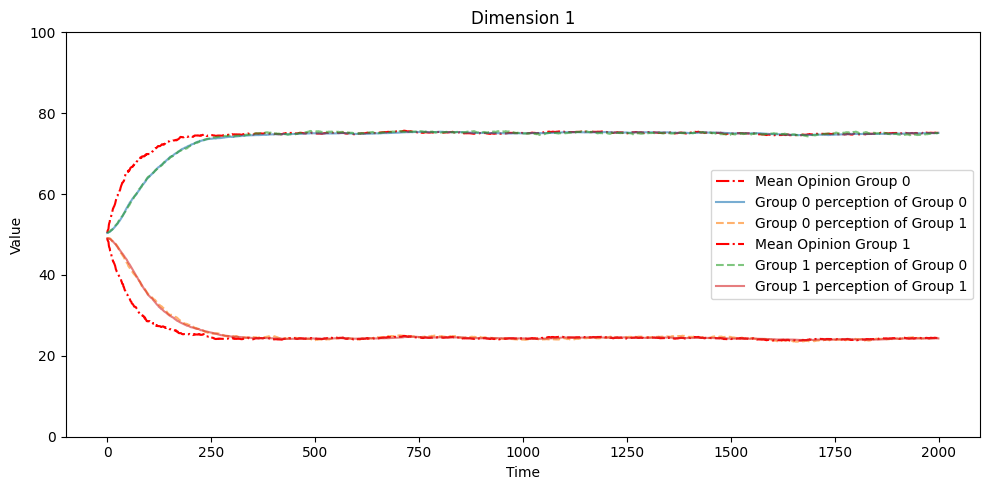

In [ ]:
plines = testSim.plot_group_values2()

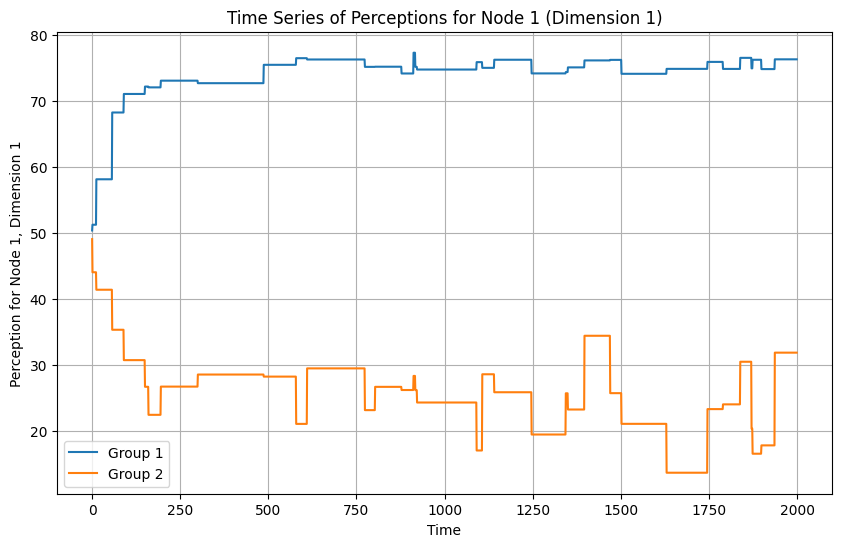

In [ ]:
#Print out the perception value for one node
node_num = 0
dim_num = 0

# Create a figure for the plot
plt.figure(figsize=(10, 6))

# Loop through each group and plot the timeseries
for g in range(testSim.num_groups):
    # Extract the time series for the current group (assuming the last dimension is time)
    timeseries = testSim.G[node_num, g, dim_num, :]

    # Plot the time series
    plt.plot(timeseries, label=f'Group {g+1}')  # You can customize the label if necessary

# Add plot labels and legend
plt.xlabel('Time')
plt.ylabel(f'Perception for Node {node_num + 1}, Dimension {dim_num + 1}')
plt.title(f'Time Series of Perceptions for Node {node_num + 1} (Dimension {dim_num + 1})')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## Model 14 - Sampling + Attract





In [ ]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import time

In [ ]:
class GroupshiftSim():

  def __init__(self, G, N, N_adj, temp, lowvalence, highvalence, aWidth, rWidth, attractSS, repulseSS):
    # This function assumes the following shapes:
    # N = np.random.uniform(0, 100, size=(num_nodes, dims))    #   Node opinion matrix
    # N_adj = np.zeros((num_nodes, timesteps))    #   N_adj matrix
    # G = np.zeros((num_nodes, num_groups, dims, timesteps)) # Group matrix, with each node having a group perception

    self.G = G
    self.N = N
    self.N_adj = N_adj
    self.lowvalence = lowvalence
    self.highvalence = highvalence
    self.aWidth = aWidth
    self.rWidth = rWidth
    self.temp = temp #Number of nodes to flip per timestep
    self.attractSS = attractSS
    self.repulseSS = repulseSS

    #Pull out num_nodes, num_groups, and dims from the arrays
    self.num_nodes, self.dims = N.shape
    _, self.num_groups, _, self.timesteps = G.shape

    # List out who will flip, in order
    self.flip_order = np.random.randint(0,num_nodes,size=(timesteps))

    #Other business
    self.initialize_G()

  def initialize_G(self):
    # INSTANTIATE INITIAL GROUP VALUES
    sums = np.zeros((self.num_groups, self.dims))
    np.add.at(sums, self.N_adj[:, 0].astype(int), self.N)
    counts = np.bincount(self.N_adj[:, 0].astype(int), minlength=self.num_groups)  # Calculate the number of nodes in each group
    counts[counts == 0] = 1  # Avoid division by zero by replacing zero counts with one (the corresponding sums are zero, so the division result will still be zero)

    # Calculate the mean of node values for each group
    mean_values = sums / counts[:, np.newaxis]

    # Duplicate mean_values for each node
    self.G[:, :, :, 0] = np.tile(mean_values, (self.num_nodes, 1, 1)).reshape(self.num_nodes, self.num_groups, self.dims)

#=======================================================
# Simulation functions
#=======================================================

  def runSimulation(self):
    for t in tqdm(range(1,self.timesteps)):
      affected_nodes = np.random.choice(range(self.num_nodes), self.temp, replace=False)
      self.carryOver(t)
      self.switch_group(t, affected_nodes)
      # self.repulseAttract(t, affected_nodes)
      self.sampleSample(t, affected_nodes)

  def carryOver(self, t):
      # Take assignments from the previous timestep for all nodes
      self.N_adj[:, t] = self.N_adj[:, t-1]

      #Carry over everyone's perceptions to the next time step
      self.G[:,:,:,t] = self.G[:,:,:,t-1]

  def switch_group(self, t, affected_nodes):
      for node_idx in affected_nodes:
      # Node to be updated
        node_values = self.N[node_idx]

        # Compute distances of this node to all group centroids from the previous timestep
        distances = np.linalg.norm(node_values - self.G[node_idx, :, :, t-1], axis=1)

        # Find the closest group
        closest_group = np.argmin(distances)

        # Update group assignment for this node
        self.N_adj[node_idx, t] = closest_group

  def attract(self, t, node_idx):
      # Node to be updated
      effects = np.zeros_like(self.G[node_idx, :, :, t]) # .shape = (num_groups, dims)

      # For the group that node is in
      g = int(self.N_adj[node_idx, t])

      # Get member valences/opinions for the current timestep
      members_idx = np.where(self.N_adj[:, t] == g)[0]
      membervalences = self.N[members_idx]

      if len(members_idx) == 0:
        return effects

      # Compute the distances & update based on the previous group's opinion
      op = self.G[node_idx, g, :, t-1]
      pointing = np.sign(membervalences - op)
      distance = np.abs(membervalences - op)
      delta_op = pointing * np.exp(-1 * (1/self.aWidth) * distance)# * (1/len(members_idx))

      # Sum the changes and apply bounds
      effects[g] = delta_op.sum(axis=0) #Sums over dims

      return effects

  def repulse(self, t, node_idx):
      # Node to be updated
      #node_idx = self.flip_order[t]
      effects = np.zeros_like(self.G[node_idx, :, :, t])
      # For each group
      for i in range(self.G[node_idx].shape[0]):
          # Calculate repulsion from all other groups based on the previous group's opinion
          op = self.G[node_idx, i, :, t-1]
          aggregated_delta = np.zeros(op.shape)

          for j in range(self.G[node_idx].shape[0]):
              if i != j:  # We don't want self-repulsion
                  pointing = -np.sign(self.G[node_idx, j, :, t-1] - op)
                  distance = np.abs(self.G[node_idx, j, :, t-1] - op)
                  delta_op = pointing * np.exp(-1 * (1/self.rWidth) * distance)

                  # Accumulate the changes for the current group

                  aggregated_delta += delta_op

          # Update the group opinion using the accumulated repulsion effects and enforce bounds
          effects[i] = aggregated_delta

      return effects

  def repulseAttract(self, t, affected_nodes, use_attraction=True, use_repulsion=True):
      for node_idx in affected_nodes:
        # Node to be updated
        #node_idx = self.flip_order[t]
        total_effects = np.zeros_like(self.G[node_idx, :, :, t])

        if use_attraction:
            attraction_effects = self.attract(t, node_idx)
            total_effects += attraction_effects

        if use_repulsion:
            repulsion_effects = self.repulse(t, node_idx)
            total_effects += repulsion_effects

        new_opinions = self.G[node_idx, :, :, t-1] + total_effects
        self.G[node_idx, :, :, t] = np.clip(new_opinions, self.lowvalence, self.highvalence)

  def Sample(self, t, node_idx): #This function runs sampling for all cases
      effects = np.zeros_like(self.G[node_idx, :, :, t]) # (G , dims) matrix
      g = int(self.N_adj[node_idx, t])
      # For each group
      for i in range(self.num_groups):
          if i==g:
              sample_size = self.attractSS
          else:
              sample_size = self.repulseSS

          members_idx = np.where(self.N_adj[:, t] == i)[0] # Get members of that group
          membervalences = self.N[members_idx]

          if len(members_idx) == 0:
              effects[i] = self.G[node_idx, i, :, t-1] # Maintain previous perception
          elif len(members_idx) < sample_size < 0:
              raise ValueError("Sample size is too large for the number of members in the group.")
          else:
              random_indices = np.random.choice(membervalences.shape[0], sample_size, replace=False)
              effects[i] = np.mean(membervalences[random_indices], axis=0) #Sum over dimensions of the sample

      # Update that node's perceptions
      self.G[node_idx, :, :, t] = np.clip(effects, self.lowvalence, self.highvalence)

      return effects

  def SampleAttract(self, t, node_idx): #This function runs sampling for all cases
      effects = np.zeros_like(self.G[node_idx, :, :, t]) # (G , dims) matrix
      #WARNING: "effects" here refers to the final outcome, not the effects to be added. This is an ambiguation issue with the repulseAttract() setup
      g = int(self.N_adj[node_idx, t])
      # For each group
      for i in range(self.num_groups):
          if i==g:
              sample_size = self.attractSS
          else:
              sample_size = self.repulseSS

          members_idx = np.where(self.N_adj[:, t] == i)[0] # Get members of that group
          membervalences = self.N[members_idx]

          if len(members_idx) == 0:
              effects[i] = self.G[node_idx, i, :, t-1] # Maintain previous perception
          elif len(members_idx) < sample_size < 0:
              raise ValueError("Sample size is too large for the number of members in the group.")
          else:
              random_indices = np.random.choice(membervalences.shape[0], sample_size, replace=False)
              if i==g: #If it's your own group, then perform attraction
                  working_values = membervalences[random_indices]
                  op = self.G[node_idx, g, :, t-1]
                  pointing = np.sign(working_values - op)
                  distance = np.abs(working_values - op)
                  delta_op = pointing * np.exp(-1 * (1/self.aWidth) * distance) * (1/sample_size) # * (1/len(members_idx))
                  effects[i] = self.G[node_idx, i, :, t-1] + delta_op.sum(axis=0) #Sums over dims
              else:
                  effects[i] = np.mean(membervalences[random_indices], axis=0) #Sum over dimensions of the sample

      # Update that node's perceptions
      self.G[node_idx, :, :, t] = np.clip(effects, self.lowvalence, self.highvalence)

      return effects

  def sampleSample(self, t, affected_nodes):
      for node_idx in affected_nodes:
          self.SampleAttract(t,node_idx)


#=======================================================
# Plotting functions
#=======================================================

  def plot_group_values2(self):
      # Create a figure and axis
      fig, ax = plt.subplots(self.dims, figsize=(10, 5 * self.dims))

      # If there's only one dimension, make ax an array for consistency
      if self.dims == 1:
          ax = [ax]

      # For each dimension and each group
      for d in range(self.dims):
          #perceptionlines = {}
          for group in range(self.num_groups):
              #Calculate mean opinions of constituents
              mean_opinions = []
              for t in range(self.timesteps):
                  group_members = self.N[self.N_adj[:, t] == group]
                  mean_opinion = np.mean(group_members[:, d])
                  mean_opinions.append(mean_opinion)
              ax[d].plot(mean_opinions, '-.', label=f'Mean Opinion Group {group}')

              # Calculate and plot the mean perception of the constituents for the current group over time
              for perception_group in range(self.num_groups):

                  mean_perceptions = []
                  for t in range(self.timesteps):
                      # Get the members of the group
                      group_members = np.where(self.N_adj[:, t] == group)[0]
                      if len(group_members) > 0:
                          mean_perception = np.mean(self.G[group_members, perception_group, d, t])
                      else:
                          mean_perception = np.nan
                      mean_perceptions.append(mean_perception)

                  # Set line style based on whether the group is perceiving itself or another group
                  if group == perception_group:
                      linestyle = '-'
                  else:
                      linestyle = '--'

                  ax[d].plot(mean_perceptions, label=f'Group {group} perception of Group {perception_group}', linestyle=linestyle, alpha=0.6)
                  #perceptionlines[f'Group {group} perception of Group {perception_group}'] = mean_perceptions

                  # if perception_group == group:
                  #   diffs = np.array(mean_perceptions) - np.array(mean_opinions)
                  #   print( np.mean( diffs[self.timesteps - 500:] ) )

          ax[d].set_title(f'Dimension {d + 1}')
          ax[d].set_xlabel('Time')
          ax[d].set_ylabel('Value')
          ax[d].legend()
          ax[d].set_ylim((self.lowvalence, self.highvalence))

      plt.tight_layout()
      plt.show()

      #return perceptionlines


In [ ]:
num_nodes = 1000
num_groups = 2
timesteps = 10000
dims = 1
temp = 20
lowvalence = 0
highvalence = 100
aWidth = 50 # 0 to 10
rWidth = 20 # Less than 50?
attractSS = 100
repulseSS = 10

#   Node opinion matrix
N = np.random.uniform(0, 100, size=(num_nodes, dims))

#   N_adj matrix
N_adj = np.zeros((num_nodes, timesteps))
N_adj[:,0] = np.random.randint(0,num_groups,size=(num_nodes))

G = np.zeros((num_nodes, num_groups, dims, timesteps))

#=======================================================
# Initial state
#=======================================================

testSim = GroupshiftSim(G, N, N_adj, temp, lowvalence, highvalence, aWidth, rWidth, attractSS, repulseSS)
testSim.runSimulation()

100%|██████████| 9999/9999 [00:53<00:00, 185.68it/s]


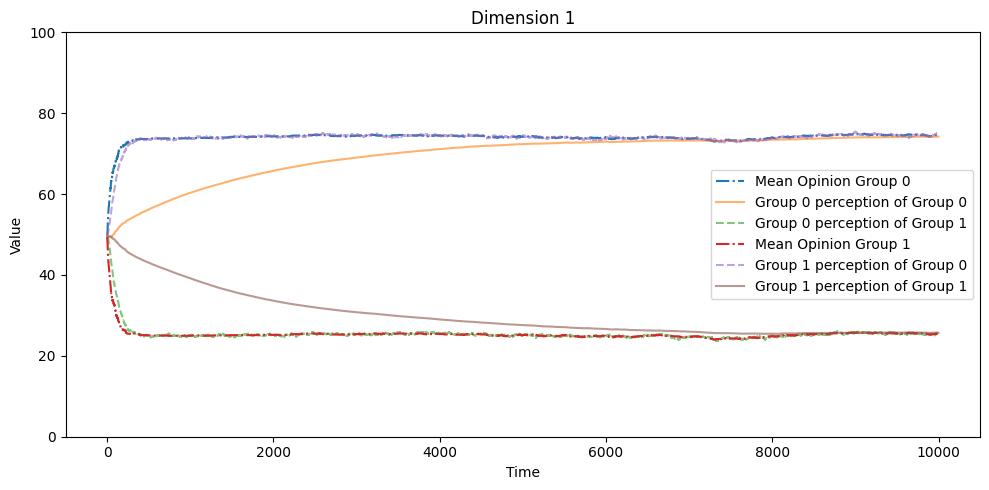

In [ ]:
plines = testSim.plot_group_values2()

In [ ]:
group0_mem = np.where(testSim.N_adj[:, -1] == 0)[0]
print( len(group0_mem) )
group1_mem = np.where(testSim.N_adj[:, -1] == 1)[0]
print( len(group1_mem) )

489
511


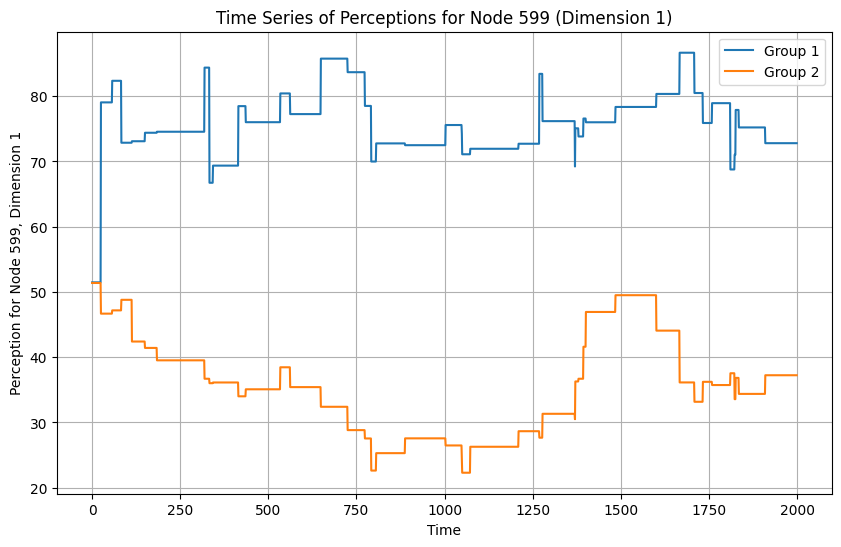

In [ ]:
#Print out the perception value for one node
node_num = np.random.randint(0,testSim.num_nodes)
dim_num = 0

# Create a figure for the plot
plt.figure(figsize=(10, 6))

# Loop through each group and plot the timeseries
for g in range(testSim.num_groups):
    # Extract the time series for the current group (assuming the last dimension is time)
    timeseries = testSim.G[node_num, g, dim_num, :]

    # Plot the time series
    plt.plot(timeseries, label=f'Group {g+1}')  # You can customize the label if necessary

# Add plot labels and legend
plt.xlabel('Time')
plt.ylabel(f'Perception for Node {node_num + 1}, Dimension {dim_num + 1}')
plt.title(f'Time Series of Perceptions for Node {node_num + 1} (Dimension {dim_num + 1})')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

#### Boostrap init

In [ ]:
num_nodes = 1000
num_groups = 2
timesteps = 10000
dims = 1
temp = 20
lowvalence = 0
highvalence = 100
aWidth = 7 # 0 to 10
rWidth = 20 # Less than 50?

df = pd.read_csv('groupshift_data.csv')
# Replace "Other" with "Independent" in the party_aff column
df['party_aff'] = df['party_aff'].replace("Other", "Independent")

df_sampled = df.sample(n=num_nodes, replace=False)

# Initialize N matrix (for opinion values)
# This will use 'LRscale_self' from df, reshape it to match the required dims
N = df_sampled['LRscale_self'].values.reshape(num_nodes, dims)

# Initialize N_adj matrix (for group/affiliation values)
# Set the first timestep with 'party_aff' from df
N_adj = np.zeros((num_nodes, timesteps))
N_adj[:, 0] = df_sampled['party_aff'].values

# G remains as initialized, unless you want to modify it based on the sampled data
G = np.zeros((num_nodes, num_groups, dims, timesteps))

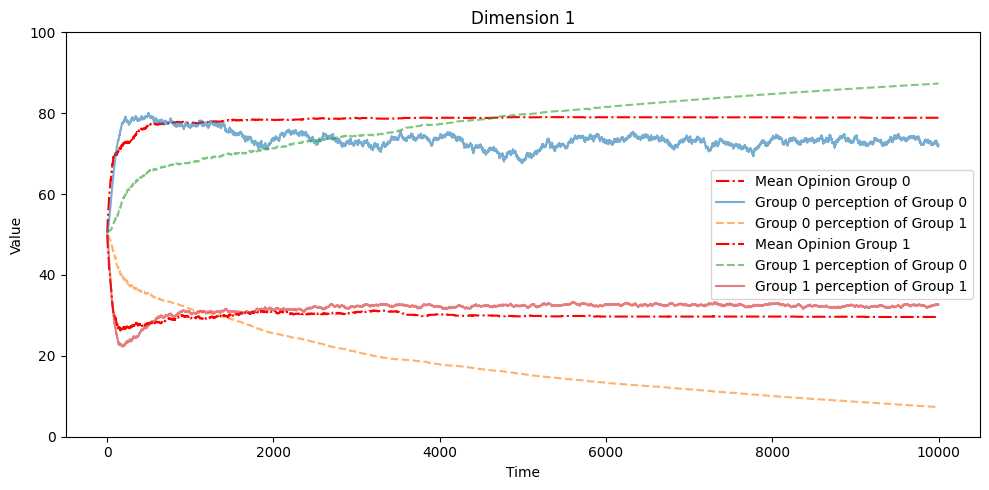

In [ ]:
plines = testSim.plot_group_values2()

### Encapsulation version

In [1]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings

In [13]:
class MechanicBase:
    def __init__(self):
        pass

    def apply(self, N, N_adj, G, *args, **kwargs):
        raise NotImplementedError("This should be implemented by subclasses")


class DoNothing(MechanicBase):
    def __init__(self):
        pass

    def apply(self, *args, **kwargs):
        pass

#===============================================================
# SCOPE mechanics
#===============================================================

class IngroupOnly(MechanicBase):
    def __init__(self):
        pass

    def apply(self, G, N, N_adj, affected_nodes, t):
        members = []
        _, num_groups, _, _ = G.shape
        for node_idx in affected_nodes:
            members_by_group = []
            for gi in range(num_groups):
                # Get the group the node is in at time t
                g = int(N_adj[node_idx, t])

                if g==gi:
                    # Get all members of the group that the node belongs to
                    members_idx = np.where(N_adj[:, t] == g)[0]
                else:
                    members_idx = np.array([])

                if not isinstance(members_idx, np.ndarray):
                    warnings.warn("Array of members selected for scoping is not a NumPy array.", UserWarning)
                members_by_group.append(members_idx)
            members.append(members_by_group)
        return members

class AsymmetricSample(MechanicBase):
    def __init__(self, ingroup_sample_size, outgroup_sample_size):
        self.ingroupSS = ingroup_sample_size
        self.outgroupSS = outgroup_sample_size

    def apply(self, G, N, N_adj, affected_nodes, t):
        members = []
        _, num_groups, _, _ = G.shape
        for node_idx in affected_nodes:
            members_by_group = []
            # Get the group the node is in at time t
            g = int(N_adj[node_idx, t])
            for gi in range(num_groups):
                if g==gi:
                    # Get all members of the group that the node belongs to
                    members_idx = np.where(N_adj[:, t] == g)[0]
                    members_idx = np.random.choice(members_idx.shape[0], self.ingroupSS, replace=False) #ISSUE: not protected for sample size > num group members
                else:
                    # Get all members of the group that the node belongs to
                    members_idx = np.where(N_adj[:, t] == gi)[0]
                    members_idx = np.random.choice(members_idx.shape[0], self.outgroupSS, replace=False) #ISSUE: not protected for sample size > num group members
                members_by_group.append(members_idx)
            members.append(members_by_group)
        return members

#===============================================================
# GLEAN mechanics
#===============================================================

class TakeMean(MechanicBase):
    def __init__(self):
        pass

    def apply(self, G, N, N_adj, affected_nodes, t, scope):
        for i, node_idx in enumerate(affected_nodes):
            relevant_scope = scope[i] #Get the scope array associated with the node being affected
            effects = np.zeros_like(G[node_idx, :, :, t]) # (G , dims) matrix
            for g, members_idx in enumerate(relevant_scope):
                if len(members_idx) <= 0:
                    effects[g] = G[node_idx, g, :, t-1] # Maintain previous perception
                else:
                    membervalences = N[members_idx]
                    effects[g] = np.mean(membervalences, axis=0) #Sum over dimensions of the sample
            G[node_idx, :, :, t] = effects

class Attract(MechanicBase):
    def __init__(self, aWidth, ingroup_only = True, normalized = False):
        self.aWidth = aWidth
        self.ingroup_only = ingroup_only
        self.normalized = normalized

    def apply(self, N, N_adj, G):
        # Mechanic A logic using self.U
        pass


    def attract(self, t, node_idx):
        # Node to be updated
        effects = np.zeros_like(self.G[node_idx, :, :, t]) # .shape = (num_groups, dims)

        # For the group that node is in
        g = int(self.N_adj[node_idx, t])

        # Get member valences/opinions for the current timestep
        members_idx = np.where(self.N_adj[:, t] == g)[0]
        membervalences = self.N[members_idx]

        if len(members_idx) == 0:
          return effects

        # Compute the distances & update based on the previous group's opinion
        op = self.G[node_idx, g, :, t-1]
        pointing = np.sign(membervalences - op)
        distance = np.abs(membervalences - op)
        delta_op = pointing * np.exp(-1 * (1/self.aWidth) * distance)# * (1/len(members_idx))

        # Sum the changes and apply bounds
        effects[g] = delta_op.sum(axis=0) #Sums over dims

        return effects

#===============================================================
# SHIFT mechanics
#===============================================================

class Repulse(MechanicBase):
    def __init__(self, U):
        self.U = U

    def apply(self, N, N_adj, G):
        # Mechanic A logic using self.U
        pass

# ================== Simulation class ==============================
class GroupshiftSim():
    def __init__(self, G, N, N_adj, C, opinion_range, SCOPE, GLEAN, SHIFT):
        # This function assumes the following shapes:
        # N = np.random.uniform(0, 100, size=(num_nodes, dims))    #   Node opinion matrix
        # N_adj = np.zeros((num_nodes, timesteps))    #   N_adj matrix
        # G = np.zeros((num_nodes, num_groups, dims, timesteps)) # Group matrix, with each node having a group perception

        self.G = G                                                              # Group perception matrix
        self.N = N                                                              # Node opinion matrix
        self.N_adj = N_adj                                                      # Node affiliation matrix
        self.C = C                                                              # Affected nodes per timestep
        self.lowvalence = opinion_range[0]
        self.highvalence = opinion_range[1]
        self.SCOPE = SCOPE
        self.GLEAN = GLEAN
        self.SHIFT = SHIFT

        #Pull out num_nodes, num_groups, and dims from the arrays
        self.num_nodes, self.dims = N.shape
        _, self.num_groups, _, self.timesteps = G.shape

    def carryOver(self, t):
        # Take assignments from the previous timestep for all nodes
        self.N_adj[:, t] = self.N_adj[:, t-1]

        #Carry over everyone's perceptions to the next time step
        self.G[:,:,:,t] = self.G[:,:,:,t-1]

    def switch_group(self, t, affected_nodes):
        for node_idx in affected_nodes:
            # Node to be updated
            node_values = self.N[node_idx]

            # Compute distances of this node to all group centroids from the previous timestep
            distances = np.linalg.norm(node_values - self.G[node_idx, :, :, t-1], axis=1)

            # Find the closest group
            closest_group = np.argmin(distances)

            # Update group assignment for this node
            self.N_adj[node_idx, t] = closest_group

    def run_simulation(self, *mechanic_params):
        for t in tqdm(range(1,self.timesteps)):
            #Define the nodes affected this timestep
            affected_nodes = C[t, :]

            #Perform the carryover mechanic
            self.carryOver(t)

            #Perform the switch groups mechanic
            self.switch_group(t, affected_nodes)

            # Set the scope of the glean effects
            scope = self.SCOPE.apply(self.G, self.N, self.N_adj, affected_nodes, t)

            #Perform glean mechanics
            self.GLEAN.apply(self.G, self.N, self.N_adj, affected_nodes, t, scope)

            #Perform shift mechanics
            self.SHIFT.apply(self.G, self.N, self.N_adj, affected_nodes, t)

            # if t > 1:
            #     print("Terminating early")
            #     break


    def plot_group_values2(self):
        # Create a figure and axis
        fig, ax = plt.subplots(self.dims, figsize=(10, 5 * self.dims))

        # If there's only one dimension, make ax an array for consistency
        if self.dims == 1:
            ax = [ax]

        # For each dimension and each group
        for d in range(self.dims):
            #perceptionlines = {}
            for group in range(self.num_groups):
                #Calculate mean opinions of constituents
                mean_opinions = []
                for t in range(self.timesteps):
                    group_members = self.N[self.N_adj[:, t] == group]
                    mean_opinion = np.mean(group_members[:, d])
                    mean_opinions.append(mean_opinion)
                ax[d].plot(mean_opinions, '-.', label=f'Mean Opinion Group {group}')

                # Calculate and plot the mean perception of the constituents for the current group over time
                for perception_group in range(self.num_groups):

                    mean_perceptions = []
                    for t in range(self.timesteps):
                        # Get the members of the group
                        group_members = np.where(self.N_adj[:, t] == group)[0]
                        if len(group_members) > 0:
                            mean_perception = np.mean(self.G[group_members, perception_group, d, t])
                        else:
                            mean_perception = np.nan
                        mean_perceptions.append(mean_perception)

                    # Set line style based on whether the group is perceiving itself or another group
                    if group == perception_group:
                        linestyle = '-'
                    else:
                        linestyle = '--'

                    ax[d].plot(mean_perceptions, label=f'Group {group} perception of Group {perception_group}', linestyle=linestyle, alpha=0.6)
                    #perceptionlines[f'Group {group} perception of Group {perception_group}'] = mean_perceptions

                    # if perception_group == group:
                    #   diffs = np.array(mean_perceptions) - np.array(mean_opinions)
                    #   print( np.mean( diffs[self.timesteps - 500:] ) )

            ax[d].set_title(f'Dimension {d + 1}')
            ax[d].set_xlabel('Time')
            ax[d].set_ylabel('Value')
            ax[d].legend()
            ax[d].set_ylim((self.lowvalence, self.highvalence))

        plt.tight_layout()
        plt.show()

        #return perceptionlines


In [14]:
#Define parameters
num_nodes = 1000
num_groups = 2
timesteps = 2000
dims = 1
lowvalence = 0
highvalence = 100

#Create N
N = np.random.uniform(lowvalence, highvalence, size=(num_nodes, dims))

# Create N_adj matrix
N_adj = np.zeros((num_nodes, timesteps))
N_adj[:,0] = np.random.randint(0,num_groups,size=(num_nodes))

#Create and set up G
G = np.zeros((num_nodes, num_groups, dims, timesteps))

sums = np.zeros((num_groups, dims))
np.add.at(sums, N_adj[:, 0].astype(int), N)
counts = np.bincount(N_adj[:, 0].astype(int), minlength=num_groups)  # Calculate the number of nodes in each group
counts[counts == 0] = 1  # Avoid division by zero by replacing zero counts with one (the corresponding sums are zero, so the division result will still be zero)
mean_values = sums / counts[:, np.newaxis] # Calculate the mean of node values for each group
G[:, :, :, 0] = np.tile(mean_values, (num_nodes, 1, 1)).reshape(num_nodes, num_groups, dims)

#Create node change order
temp = 20 #Number of nodes to change per timestep
C = np.random.randint(0,num_nodes,size=(timesteps, temp))

In [15]:
#Create mechanics
aWidth = 50 # 0 to 10
rWidth = 20 # Less than 50?
attractSS = 100
repulseSS = 10

SCOPE = IngroupOnly()
GLEAN = TakeMean()
SHIFT = DoNothing()

In [16]:
# Set DoNothing for the GLEAN mechanic
simulation = GroupshiftSim(G, N, N_adj, C, (lowvalence, highvalence), SCOPE, GLEAN, SHIFT)

In [17]:
# Run the simulation
simulation.run_simulation()

100%|██████████| 1999/1999 [00:02<00:00, 725.87it/s]


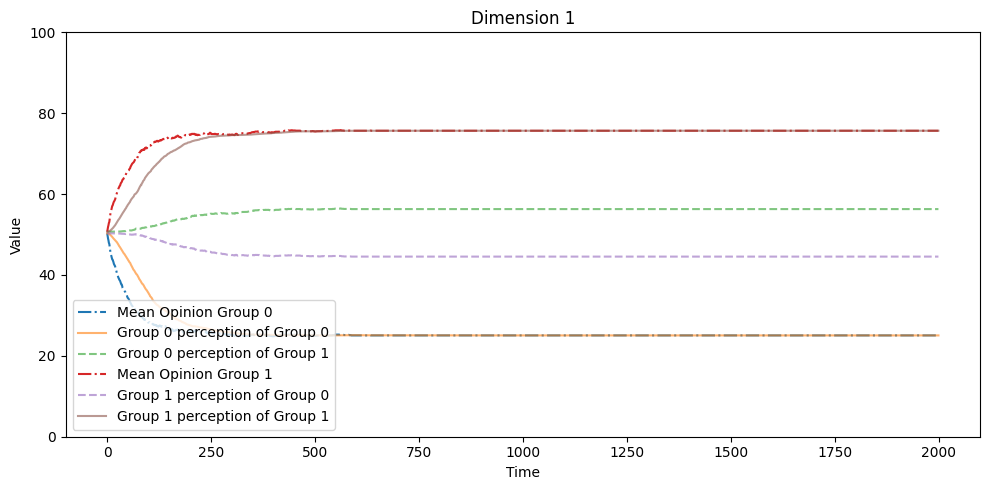

In [18]:
simulation.plot_group_values2()

# Misc code

The following code was a basic implementation of the setup that Rob suggested for repulsion and attraction.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
a = 100
b = np.array(range(1,200))

newlist = []
amp = 1
width = 50

for i in b:
  point = 1 if i<a else -1
  asdf = np.abs(a-i)
  newval = a + amp * point * np.exp(-1*(1/width)*asdf)
  #Sigmoid function?
  #newval = a + amp * point * (1/(1+np.exp(-1*(1/width)*asdf)))
  newlist.append(newval)

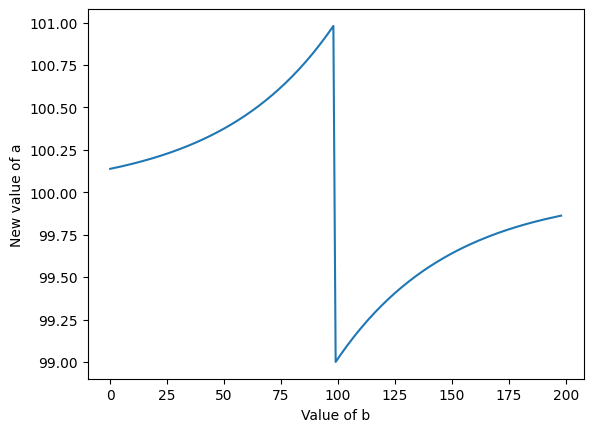

In [ ]:
plt.plot(newlist)
plt.xlabel("Value of b")
plt.ylabel("New value of a")
plt.show()

In [ ]:
a = [np.array([np.random.rand()]) for i in range(10)]
print(a)

d = distMatrix1D(a)

[array([0.57544352]), array([0.71511412]), array([0.38216625]), array([0.02574471]), array([0.14689826]), array([0.2232138]), array([0.6146809]), array([0.29023559]), array([0.81189034]), array([0.22398726])]


array([[0.        , 0.13967059, 0.19327728, ..., 0.28520794, 0.23644682,
        0.35145626],
       [0.13967059, 0.        , 0.33294787, ..., 0.42487853, 0.09677622,
        0.49112685],
       [0.19327728, 0.33294787, 0.        , ..., 0.09193066, 0.42972409,
        0.15817898],
       ...,
       [0.28520794, 0.42487853, 0.09193066, ..., 0.        , 0.52165475,
        0.06624832],
       [0.23644682, 0.09677622, 0.42972409, ..., 0.52165475, 0.        ,
        0.58790308],
       [0.35145626, 0.49112685, 0.15817898, ..., 0.06624832, 0.58790308,
        0.        ]])

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

y = []
t = 100
op = 7
neighbors = np.array([2,5,10,12,19])

amp = 1
width = 1

for i in range(t):
  for j in neighbors:
    point = 1 if op < j else -1
    asdf = np.abs(op-j)
    op += point * amp * np.exp(-1*(1/width)/asdf)
  y.append(op)

In [ ]:
print(np.mean(neighbors))
print(y[-1])

9.6
11.154095356215386


[8.29275370776584, 9.220350980967755, 9.935730309196435, 10.461893791094822, 10.80763184155332, 11.000087538369858, 11.090547354819012, 11.128698641619417, 11.144062431934815, 11.150148397085783, 11.152545049533288, 11.153486785275105, 11.15385651839057, 11.154001631261364, 11.154058577904355, 11.154080924358455, 11.154089693167283, 11.15409313404505, 11.154094484240309, 11.15409501405427, 11.154095221952131, 11.154095303530788, 11.15409533554207, 11.154095348103223, 11.154095353032192, 11.154095354966307, 11.154095355725248, 11.154095356023056, 11.154095356139917, 11.154095356185772, 11.154095356203765, 11.154095356210826, 11.154095356213597, 11.154095356214683, 11.154095356215109, 11.154095356215276, 11.154095356215343, 11.15409535621537, 11.15409535621538, 11.154095356215384, 11.154095356215386, 11.154095356215386, 11.154095356215386, 11.154095356215386, 11.154095356215386, 11.154095356215386, 11.154095356215386, 11.154095356215386, 11.154095356215386, 11.154095356215386, 11.1540953

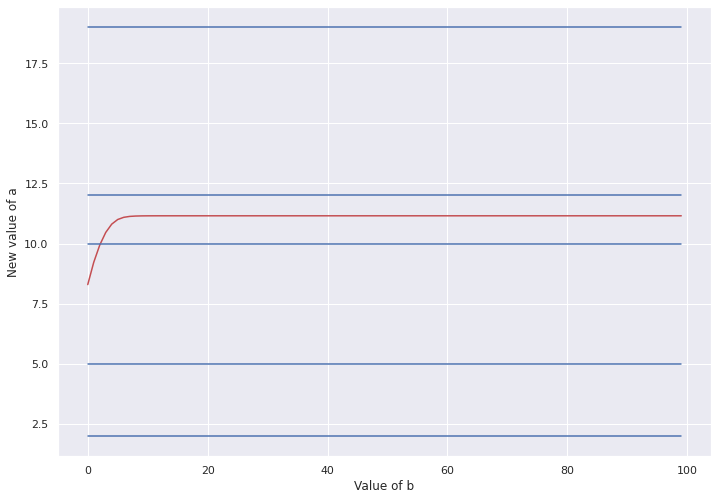

In [ ]:
print(y)
plt.plot(range(t),y,c='r')
for j in neighbors:
  plt.plot(range(t),[j]*t, c='b')
plt.xlabel("Value of b")
plt.ylabel("New value of a")
plt.show()

Possible issues:
* Maybe things won't line up right, like the groups from different times will be in the same column
* This method technically just keeps counts, but it doesn't track who specifically stays or leaves


In [ ]:
g_t0 = output_graphs[3][1]
g_t1 = output_graphs[10][1]

g_t0_set = set([hh for hh in g_t0.neighbors('Group1')])
g_t1_set = set([hh for hh in g_t1.neighbors('Group1')]) #Group 1 members for both time 3 and 4

In [ ]:
print('Num indivs in group 1 at time 3')
print(len(g_t0_set))
print('Num indivs in group 1 at time 10')
print(len(g_t1_set))

print('Overlap')
print(len(g_t0_set.intersection(g_t1_set)))

Num indivs in group 1 at time 3
99
Num indivs in group 1 at time 10
93
Overlap
62


In [ ]:
# Function to check for mix of 0s and 1s in any row
def find_mixed_rows(matrix):
    mixed_indices = []
    for i, row in enumerate(matrix):
        contains_zeros = np.any(row == 0)
        contains_ones = np.any(row == 1)
        if contains_zeros and contains_ones:
            mixed_indices.append(i)
    return mixed_indices

matrix = testSim.N_adj

# Get indices of rows with a mix of 0s and 1s
mixed_rows = find_mixed_rows(matrix)

if mixed_rows:
    print(f"Rows with a mix of 0s and 1s: {mixed_rows}")
else:
    print("No rows with a mix of 0s and 1s found.")


arr = testSim.N_adj[mixed_rows[0]]
contains_zeros = np.any(arr == 0)
contains_ones = np.any(arr == 1)

if contains_zeros and contains_ones:
    print("The array contains a mix of zeros and ones.")

print(list(testSim.N_adj[mixed_rows[0]]))

print(np.where(testSim.flip_order == mixed_rows[0])[0][0])
print(np.where(testSim.N_adj[mixed_rows[0]] == 0)[0][0])